In [ ]:
%%bash
unzip "/content/help.zip"

Archive:  /content/help.zip
  inflating: colors.py               
  inflating: __MACOSX/._colors.py    
  inflating: losses.py               
  inflating: __MACOSX/._losses.py    
  inflating: plot_dist.py            
  inflating: torch_class.py          
  inflating: __MACOSX/._torch_class.py  
  inflating: train.py                
  inflating: __MACOSX/._train.py     
  inflating: utils_2.py              
  inflating: w_initializer.py        
  inflating: __MACOSX/._w_initializer.py  


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from utils_2 import filter_subject,filter_LAP,calc_TimeWindowedData
import os
import plotly.express as px

In [ ]:
def color_map(rgb_data):
    rgb_data_3d = rgb_data.reshape(1,rgb_data.shape[0],-1)
    plt.figure(figsize=(20,1))
    plt.imshow(rgb_data_3d,aspect='auto',extent=(0, rgb_data_3d.shape[1],0,1))
    
    
def convert_to_hex(latent_3D,range_):
    rgb_data = rgb_mapping(latent_3D)
    color_map(rgb_data[:range_])
    rgb_data_255 = rgb_data*255
    rgb_data_rounded=[]
    for ar in rgb_data_255:
        ar=[ int(x.round()) for x in ar ]
        rgb_data_rounded.append(ar)
    rgb_data_rounded_list_tuple = [tuple(x) for x in rgb_data_rounded ]
    hex_list = rgb_hex(rgb_data_rounded_list_tuple)
    return hex_list[:range_]

In [ ]:

%matplotlib inline
%config InlineBackend.figure_format ='retina'
warnings.filterwarnings("ignore")
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
COLORS = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#93D30C","#8F00FF"]
sns.set_palette(sns.color_palette(COLORS))
register_matplotlib_converters()

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
from losses import sparsity_activation,mse_fct,KL_divergence,loss_fn
from w_initializer import weights_init_normal,weights_init_uniform
from colors import *
import torch
import torch.nn as nn
import torch.nn.functional as F


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import linalg as LA

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

def filter_LAP(data, LAP) :
    df=data[data['LAPS'].str.contains(LAP, na=False)]
    df.reset_index(drop=True,inplace=True)
    return(df)



def filter_subject(data,S) :
    df=data[data['personId'].str.contains(S, na=False)]
    df.reset_index(drop=True,inplace=True)
    return(df)

def calc_TimeWindowedData(df_raw, window_duration, col_use=None, speed_col_index=None):
    raw_data_array = df_raw.values #type = object

    nlines,ncols= raw_data_array.shape

    if(col_use==None):#use all columns
        col_use=range(ncols)

    nfeatures = len(col_use)

    if(speed_col_index==None):
        startindex = 0
    else:
        speed = raw_data_array[:,speed_col_index]
        indexes= np.where(speed>0.)
        i0 = indexes[0].real
        startindex = i0[0]#premier point où la vitesse est non nulle


    nblines = nlines - startindex  # number of lines we actually used  
    Tdonnees = raw_data_array[startindex:-1,col_use]
    Tnormalized = MinMaxScaler().fit_transform(Tdonnees)
    Nwindows = Tnormalized.shape[0] - window_duration + 1
    TimeWindowedData = np.zeros( (Nwindows, window_duration*nfeatures))
    print(Nwindows)
    for i in range(Nwindows):
        Acrop = Tnormalized[i:i+window_duration,:]
        TimeWindowedData[i,:] = np.reshape(Acrop,window_duration*nfeatures)


    return TimeWindowedData

In [ ]:
def plot_helper(data,range_,seq):
    col_use = features_ 
    window_duration = 10
    nfeatures = len(col_use)
    startindex = 0
    speed_col_index=0 # à partir de zéro
    TimeWindow = window_t

    windowing_data = calc_TimeWindowedData(data, TimeWindow, col_use, speed_col_index)
    windowing_data = create_sequences(windowing_data,seq)

    windowing_data = model.to_torch(windowing_data)
    windowding_data_cuda = windowing_data.to(device)
    latent_3D = model.encoder(windowding_data_cuda)
    ## in the convert_to_hex function ,the rgb map is done
    latent_3D_numpy = latent_3D.cpu().detach().numpy()
    hex_list =convert_to_hex(latent_3D_numpy,range_)
    
    return hex_list


def plot_weight(weights):
      latent_weight = weights.detach().numpy()
      g =sns.distplot(latent_weight[:,0]).set_title("data distribution")
      g =sns.distplot(latent_weight[:,1])
      g =sns.distplot(latent_weight[:,2])

      plt.legend(labels=['1st_dimension','2nd_dimension','3rd_dimension'])
      plt.show(g)



#def plot_graph(data,features,range_,labels):


#  df=df_test.copy()
#  df=df[features]
#  feat=df.columns
#  l=len(feat)
#  fig,ax=plt.subplots(l,1,figsize=(20,10))
#  #fig.suptitle("Sujet  {} {}".format(Sujets[subject],LAPS[laps]))
# for i in range(l):
      
#      ax[i].scatter(list(df.index),df[feat[i]],c=labels,cmap='plasma',linewidth=2.0)
#      ax[i].set_title('Profile of feature {}'.format(feat[i]))

def visualize_lap(data,model,range_):
  
    hex_list = plot_helper(data,range_ = range_,seq=sequence_length)
    plt.figure(figsize=(20,10))
    PtsList = data.values
    XYpts = PtsList[0:-3+1,[1, 0]]
    XYpts = XYpts[:range_]
    plt.scatter(XYpts[:len(hex_list),1],XYpts[:len(hex_list),0],c=hex_list,linewidth=5)
    
    plt.title("LAP  OF THE TEST DATASET")
    plt.show()

def plot_lap_graph(data,model,subject,lap,features=["Velocity","Acceleration","Curvature"]):

  df_test_s = filter_subject(data,Sujets[subject])
  df_test = filter_LAP(df_test_s,LAPS[lap])

  visualize_lap(df_test,
                model,range_ = df_test.shape[0])
  plot_graph(df_test,
             features,df_test.shape[0])
  
def lap_driver(subject,lap):
  df_test_s = filter_subject(data,Sujets[subject])
  df_test = filter_LAP(df_test_s,LAPS[lap])

  return df_test
def plot_graph(data,features,labels,subject,laps):
  df_test_s = filter_subject(data,Sujets[subject]) ## B0AE19

  df_test = filter_LAP(df_test_s,LAPS[laps])

  df_test = df_test[:len(labels)]

  #df_test["labels"] = labels

  df=df_test.copy()
  df=df[features]
  feat=df.columns
  l=len(feat)
  fig,ax=plt.subplots(l,1,figsize=(20,10))
  #fig.suptitle("Sujet  {} {}".format(Sujets[subject],LAPS[laps]))
  for i in range(l):
      
      ax[i].scatter(list(df.index),df[feat[i]],c=labels,cmap='plasma',linewidth=1.0)
      ax[i].set_title('{}'.format(feat[i]))

def encoding_(subject,lap):

  df_test = lap_driver(subject,lap)
  df_test_w = calc_TimeWindowedData(df_test, TimeWindow, col_use, speed_col_index)

  df_test_w = create_sequences(df_test_w,sequence_length)
  encoding_torch = model.encoder(torch.from_numpy(df_test_w).float().to(device))
  encoding =  encoding_torch.detach().cpu().numpy()

  return encoding

def create_sequences(data, seq_length):
    xs = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        xs.append(x)

    return np.array(xs)

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Data_all.csv")
#data = data.drop("Unnamed: 0",axis=1)
Sujets = ['02E7B8','357EC1','B0AE19','3409B8','4486C7','48FBEE','4C3614','13790E','0D2501','9B434A','F2C674']
LAPS =['LAP_1', 'LAP_2', 'LAP_3', 'LAP_4', 'LAP_5', 'LAP_6']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data["personId"].unique()

array(['4486C7', 'B0AE19', '02E7B8', '0D2501', '13790E', '3409B8',
       '357EC1', '48FBEE', '4C3614', '9B434A', 'F2C674'], dtype=object)

In [ ]:
def throttlePos_regulation(data):
  data_list_throttle = list(data["payload.throttlePos"])
  data_list_velocity = list(data["Velocity"])
  data_list_throttle_real = []
  for i in range(len(data_list_throttle)):
    if data_list_velocity[i] <= 0.2 :
      data_list_throttle_real.append(0)
    else:
      data_list_throttle_real.append(data_list_throttle[i])
  return data_list_throttle_real



In [ ]:
def e(subject):
  df_train_s = filter_subject(data,Sujets[subject])


  df_train_2 = filter_LAP(df_train_s,LAPS[1])
  df_train_3 = filter_LAP(df_train_s,LAPS[2])
  df_train_4 = filter_LAP(df_train_s,LAPS[3])
  df_train_5 = filter_LAP(df_train_s,LAPS[4])
  df_train_6 = filter_LAP(df_train_s,LAPS[5])
  df_train_s = pd.concat([df_train_2,df_train_3,df_train_4],axis=0)

  return df_train_s

 

# With regularization of throttlePos

In [ ]:
data["payload.throttlePos"] = throttlePos_regulation(data)


df_train_s = pd.concat([e(2),e(8),e(9),e(10)],axis=0)
df_train_s.shape




(15410, 14)

In [ ]:
df_train_s.columns

Index(['payload.Longitude', 'payload.Latitude', 'Velocity', 'AccelNcomp',
       'Acceleration', 'Curvature', 'AT', 'dynamic_curv', 'dateTime',
       'payload.handleSteerPos', 'payload.frontBrakePos',
       'payload.throttlePos', 'LAPS', 'personId'],
      dtype='object')

In [ ]:
df_train_s.columns

Index(['payload.Longitude', 'payload.Latitude', 'Velocity', 'AccelNcomp',
       'Acceleration', 'Curvature', 'AT', 'dynamic_curv', 'dateTime',
       'payload.handleSteerPos', 'payload.frontBrakePos',
       'payload.throttlePos', 'LAPS', 'personId'],
      dtype='object')

In [ ]:
window_t = 1
features_ = [2,3,5,6,9,10,11]

In [ ]:
raw_data_array = df_train_s.values #type = object
col_use = features_ #'AccelNcomp','Velocity'
      # 'AT', 'Curvature', 'payload.handleSteerPos',
       #'payload.frontBrakePos', 'payload.throttlePos'
nlines,ncols= raw_data_array.shape
window_duration = 10
nfeatures = len(col_use)
startindex = 0
speed_col_index=0 # à partir de zéro
TimeWindow = window_t

#==============================================================================
#     Load the data (kinematics) + X-Y trajectory pts
#==============================================================================
timewindoweddatas = calc_TimeWindowedData(df_train_s, TimeWindow, col_use, speed_col_index)

train  = timewindoweddatas

15409


# GPU

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  
else:  
  dev = "cpu"  

device = torch.device(dev)  


## Modeling

In [ ]:
sequence_length =5

# Enocder Transformer

In [ ]:

class AE_LSTM(nn.Module): ## extends our class to pytorch class

    def __init__(self,
                 input_dim,
                 hidden2,
                 num_layers,
                 seq_len,
                 dim_feed,

                 dropout = 0.5,
                 device='cpu'
                 ):
      super(AE_LSTM, self).__init__()
      self.input_dim = input_dim

      self.hidden2 =  hidden2
      self.num_layers = num_layers
      self.dropout = nn.Dropout(p=dropout)
      self.dim_feed = dim_feed
      self.seq_len = seq_len
      self.leaky_relu = nn.LeakyReLU()
      self.sigmoid = nn.Sigmoid()
      self.softmax = nn.Softmax()
      self.encode_0 = nn.Linear(7,3)
      self.norm = nn.LayerNorm(3)
      self.attention = nn.TransformerEncoderLayer(d_model=7, nhead=1,dim_feedforward=dim_feed,dropout=dropout)
      self.attention_encoder = nn.TransformerEncoder(self.attention, num_layers=num_layers)    


      self.decode_1 = nn.Linear(in_features = 3, out_features= hidden2)

      self.reconstructed = nn.Linear(in_features = hidden2,
                                     out_features = input_dim)
    
    def attention_encoding(self,input):
      encoding = self.encoder_c(input)
      #soft_encoding = self.softmax(encoding)
      return encoding
      
    def attention_softmax(self,input):
      return self.softmax(self.attention_encoding(input))
    def encoder_c(self,input):
      c = self.attention_encoder(input)
      b = self.leaky_relu(self.encode_0(c))

      


      return  self.norm(b)
    def encoder(self,input):
      latent = (self.encoder_c(input))
      return torch.mean(latent,dim=1)

    def decoder(self,latent):
      decode1 = self.leaky_relu(self.decode_1(latent))
      reconstructed = (self.reconstructed(decode1))

      return reconstructed

    def forward(self,input):
      
      encoding = self.encoder_c(input)
      decoding = self.decoder(encoding)

      return decoding

    def to_torch(self,input):
      return torch.from_numpy(input).float()


In [ ]:
def train_model(train,
                model,
                learning_rate=0.001,
                batch_size = 1,
                num_epochs=50,
                normalization_weight=1e-5,
                loss_option="mse",  #mae have a better reconstruction
                d = 10,
                 factor_scheduler = 0.8,
                l1=0,
                device="cpu"):
  

  print("Begin training....")
  optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate,weight_decay=normalization_weight)
  
  train_numpy = np.array(train,dtype="float32")
  trainloader = torch.utils.data.DataLoader(train_numpy,batch_size = batch_size)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         min_lr = 1e-5,
                                                         mode = 'min',
                                                         factor=factor_scheduler,
                                                         verbose=True
                                                         ,patience=10)

  train_hist = np.zeros(num_epochs)
  
  for e in range(num_epochs):
    for data in trainloader:
      data = data.to(device)

    #model.reset_hidden_state()
      optimizer.zero_grad()
      reconstructed = model(data)
      #
      if loss_option == "mse":

        loss = torch.nn.MSELoss(reduction="sum")(data,reconstructed)
      elif loss_option =="mae":
        loss = torch.nn.L1Loss(reduction="sum")(data,reconstructed)
      elif loss_option =="huber": # huber loss
        loss = torch.nn.SmoothL1Loss(reduction="sum")(data,reconstructed)
      else:
        loss = torch.nn.CosineSimilarity()(data,reconstructed)
      
      #loss_ = loss + 0.5*(1/(torch.abs(l)) + 0.0001)
     # encoding = model.encoder(data)
     # loss_ = torch.nn.KLDivLoss()(encoding[:,1].reshape(-1,1),encoding[:,0].reshape(-1,1))
      all_linear1_params = torch.cat([x.view(-1) for x in model.parameters()])
      l1_regularization = l1 * torch.norm(all_linear1_params, 1)
      loss = loss + l1_regularization
      #loss = torch.relu(1/l) + loss
      train_hist[e] = loss.item()



      loss.backward()

      optimizer.step()

      
    if e%d == 0:
      #l = torch.nn.KLDivLoss()(model.encoder(data)[:,0],model.encoder(data)[:,1]) + torch.nn.KLDivLoss()(model.encoder(data)[:,2],model.encoder(data)[:,1]) + torch.nn.KLDivLoss()(model.encoder(data)[:,0],model.encoder(data)[:,2])
      #print(torch.abs(l))
      print(f'Epoch {e} train loss:{loss.item()}')
      #print ('Epoch {} mse loss {} similarity {} '.format(e,loss.item(),loss_.item()))
    if e == num_epochs-1:
      a = plot_helper(df_test, df_test.shape[0],5)
    scheduler.step(e)

      
  print("finish !")
  return model.eval(), train_hist

(15409, 7)

In [ ]:
for sequence_length in [5,10]:
  for d in [3,10,2048,4096]:
    for drop in [0.1]:
      for b in [256]:
        for l2 in [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-7]:
          for l1 in [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]:
            for s in [1,2,3]:
              for option in ["mse","mae","huber"]:
       

      #sequence_length = 5
                train_seq = create_sequences(train,sequence_length)
                model = AE_LSTM(input_dim = 7,
                            hidden2 =5,
                            num_layers =s,

                            dropout = drop,
                            dim_feed = d,
                            seq_len = sequence_length,
                      )



                ### Bande de couleur obtenus sur le sujet 4 lap 4
                model,train_hist = train_model(train_seq,
                                        model.to(device),
                                        learning_rate=0.001,
                                        batch_size = b,
                                        num_epochs=200,
                                        normalization_weight = l2,
                                        loss_option=option,
                                        factor_scheduler = 0.99999,

                                        d = 50,
                                        l1=l1,
                                        device=device)
                torch.save(model,"model_pretrained{}_{}_{}_{}_{}_{}_{}".format(s,d,drop,b,l2,l1,option))

In [ ]:
def color_map(rgb_data):
    rgb_data_3d = rgb_data.reshape(1,rgb_data.shape[0],-1)
    plt.figure(figsize=(20,1))
    plt.imshow(rgb_data_3d,aspect='auto',extent=(0, rgb_data_3d.shape[1],0,1))
    
    
def convert_to_hex(latent_3D,range_):
    rgb_data = rgb_mapping(latent_3D)
    color_map(rgb_data[:range_])
    rgb_data_255 = rgb_data*255
    rgb_data_rounded=[]
    for ar in rgb_data_255:
        ar=[ int(x.round()) for x in ar ]
        rgb_data_rounded.append(ar)
    rgb_data_rounded_list_tuple = [tuple(x) for x in rgb_data_rounded ]
    hex_list = rgb_hex(rgb_data_rounded_list_tuple)
    return hex_list[:range_]

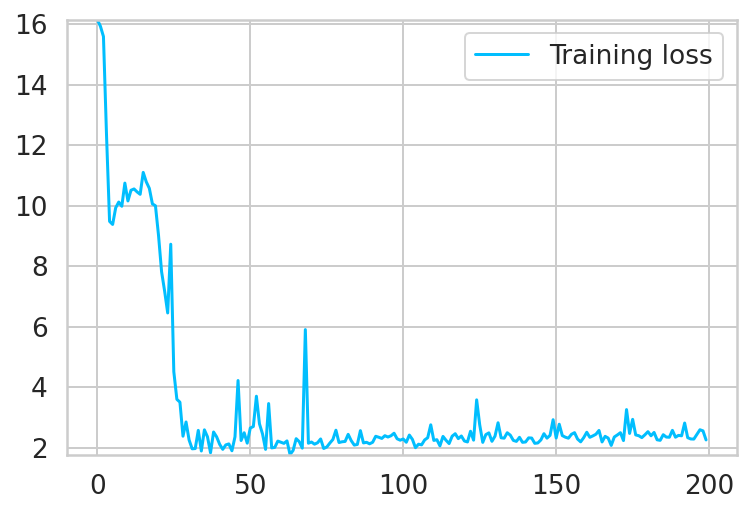

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.ylim((np.array(train_hist).min(), np.array(train_hist).max()))
plt.legend();

In [ ]:
model = torch.load("/content/model_pretrained1_3_0.1_256_0_0.1_huber")
#/content/model_pretrained1_2048_0.1_256_0.0001

1152


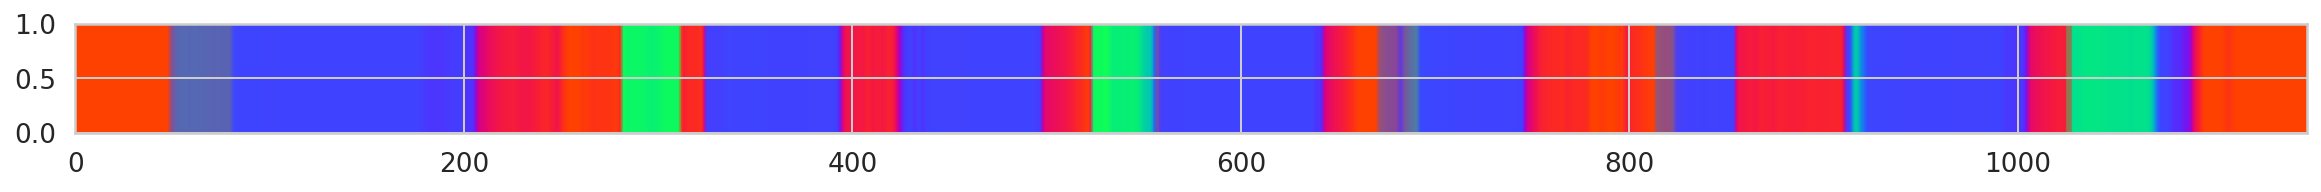

In [ ]:
df_test = lap_driver(5,2)
test = lap_driver(5,2)
a = plot_helper(df_test, df_test.shape[0],2)

# Latent Representation

In [ ]:
def plot_helper(data,range_,seq):
    col_use = features_ 
    window_duration = 10
    nfeatures = len(col_use)
    startindex = 0
    speed_col_index=0 # à partir de zéro
    TimeWindow = window_t

    windowing_data = calc_TimeWindowedData(data, TimeWindow, col_use, speed_col_index)
    windowing_data = create_sequences(windowing_data,seq)

    windowing_data = model.to_torch(windowing_data)
    windowding_data_cuda = windowing_data.to(device)
    latent_3D = model.encoder(windowding_data_cuda)
    ## in the convert_to_hex function ,the rgb map is done
    latent_3D_numpy = latent_3D.cpu().detach().numpy()
    hex_list =convert_to_hex(latent_3D_numpy,range_)
    
    return hex_list

1152
1152


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff53477f1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff53477f1d0>)

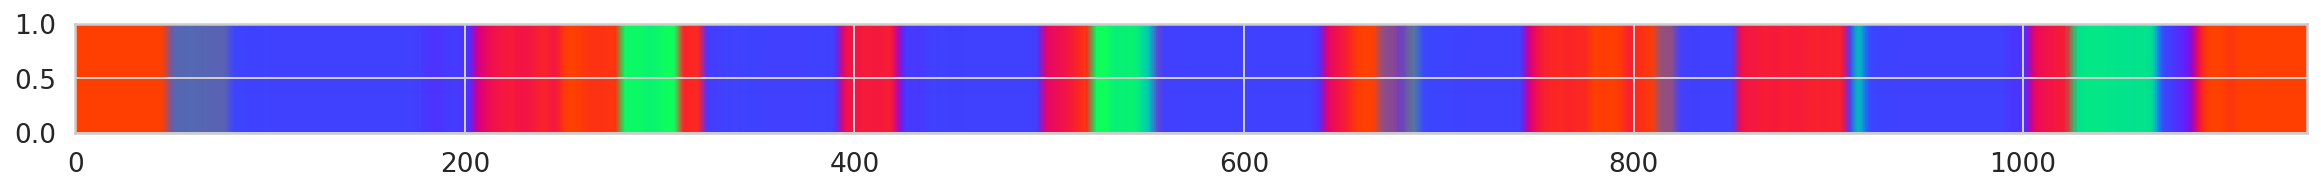

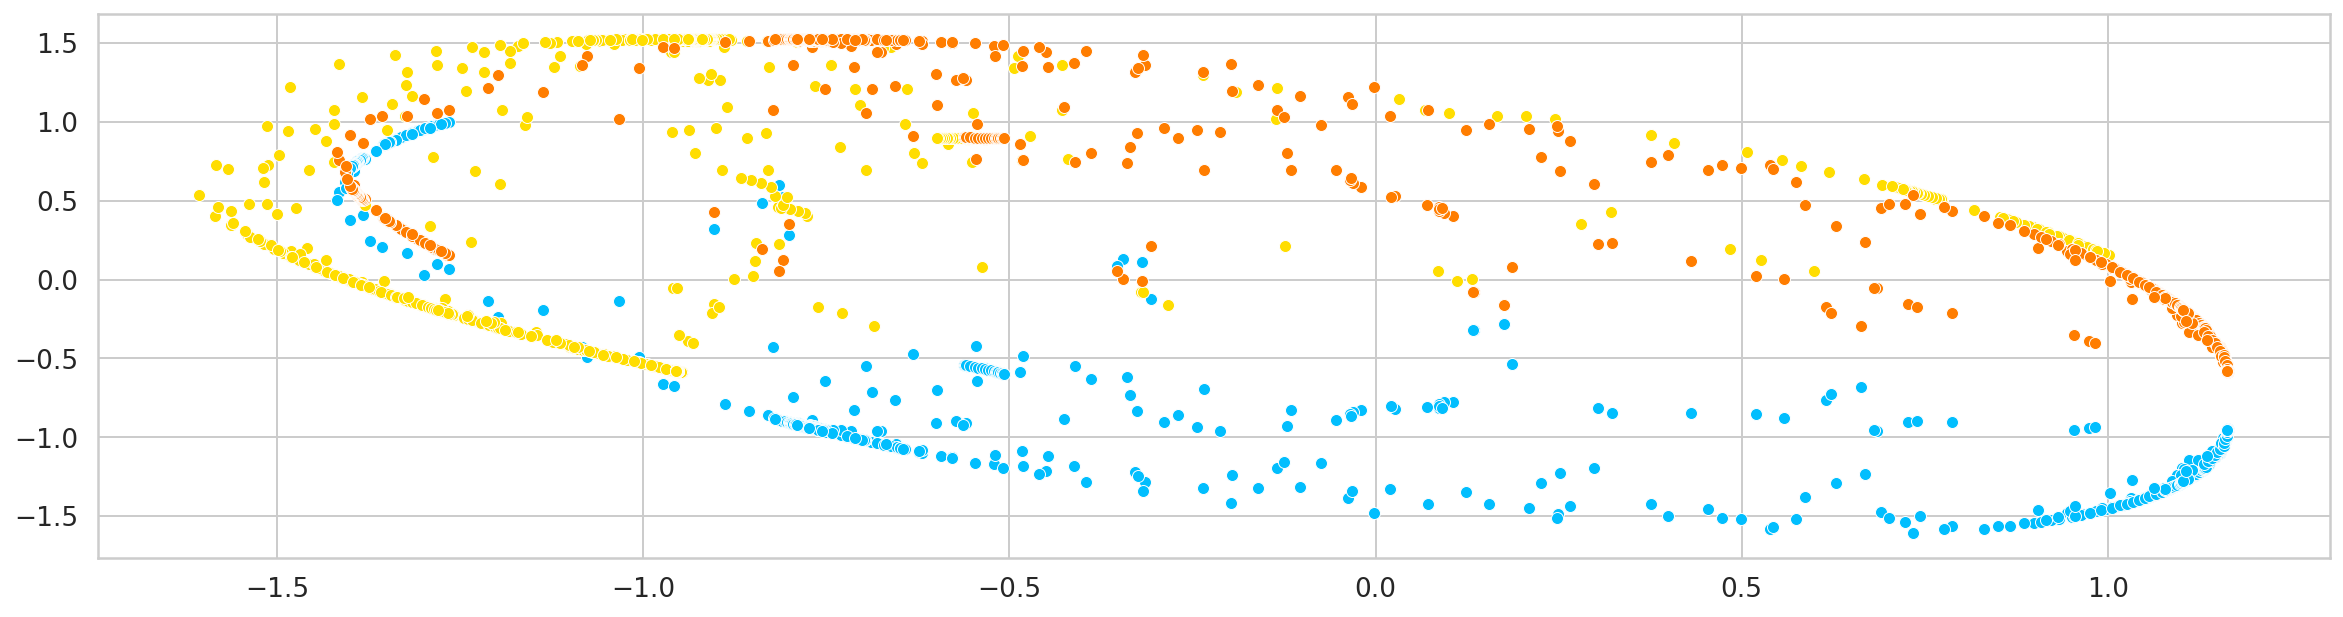

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_test = lap_driver(5,2)
def encoding_ae(subject,lap):

  df_test = lap_driver(subject,lap)
  df_test_w = calc_TimeWindowedData(df_test, TimeWindow, col_use, speed_col_index)

  df_test_w = create_sequences(df_test_w,sequence_length)
  encoding_torch = model.encoder(torch.from_numpy(df_test_w).float().to(device))
  encoding =  encoding_torch.detach().cpu().numpy()

  return encoding
a = plot_helper(df_test, df_test.shape[0],5)
encoding_ = encoding_ae(5,2)

v1 = encoding_[:,0]
v2 = encoding_[:,1]
v3 = encoding_[:,2]
fig = plt.figure(figsize=(20, 5))

v1.shape, v2.shape,v3.shape
sns.scatterplot(v1,v2) , sns.scatterplot(v2,v3) , sns.scatterplot(v1,v3)

In [ ]:
v1.max()

0.0020036807

In [ ]:
encoding_.shape

(1146, 5, 3)

1152
1152


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5347136d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff5347136d8>)

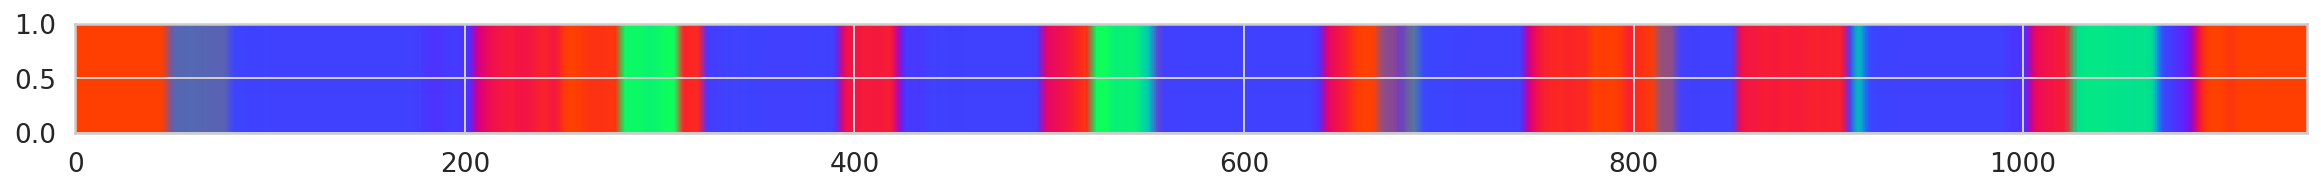

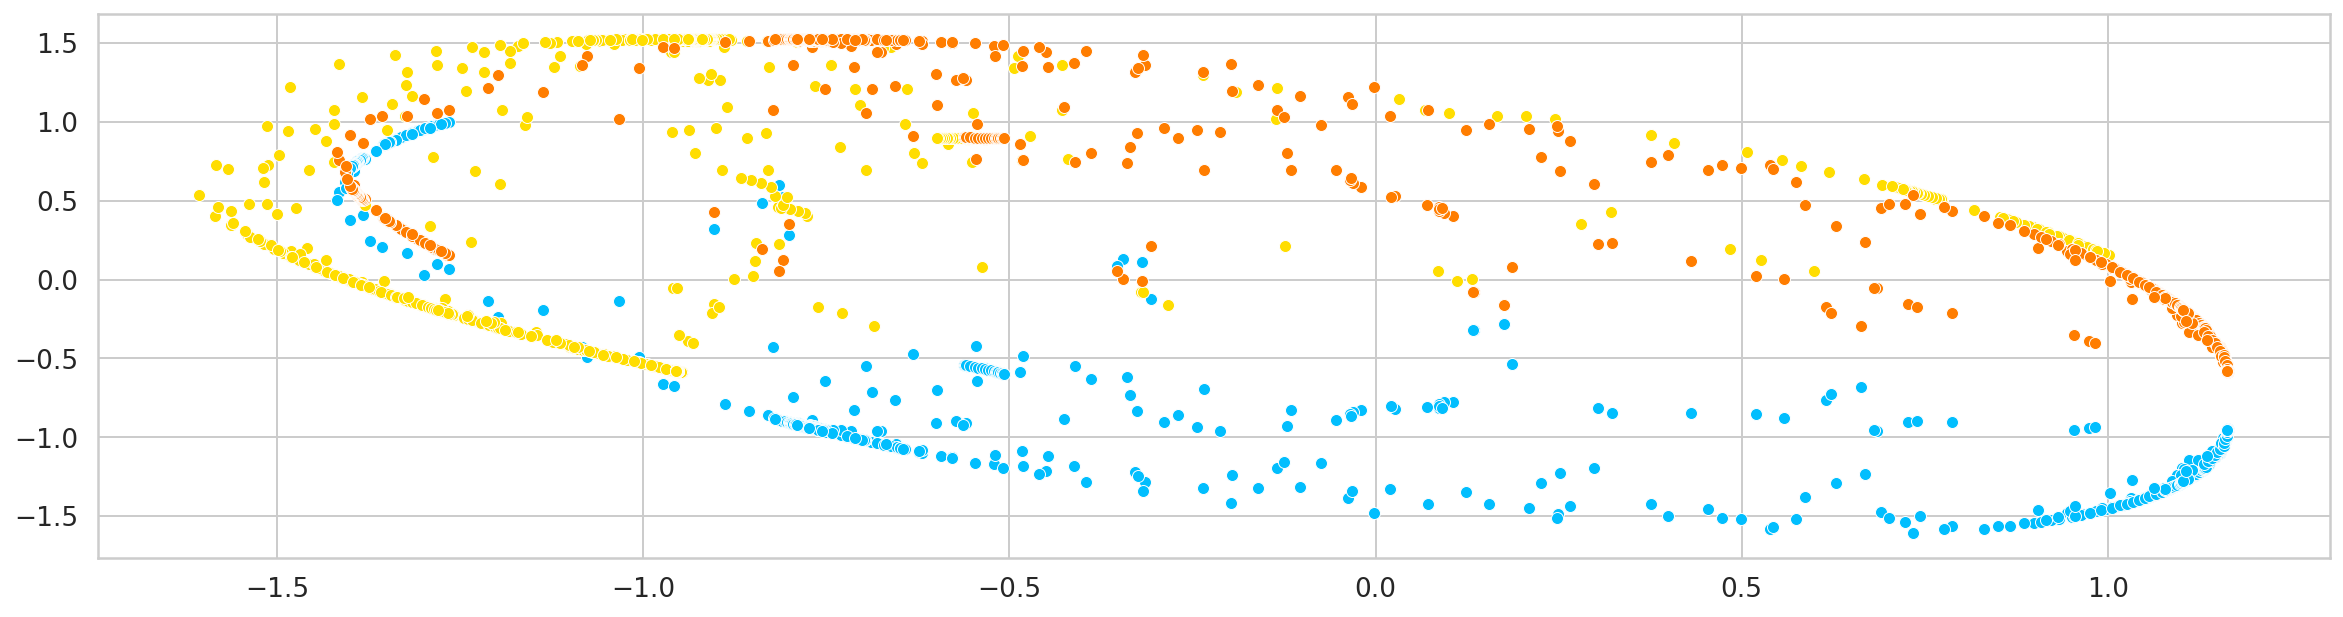

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_test = lap_driver(5,2)

a = plot_helper(df_test, df_test.shape[0],sequence_length)
encoding_ = encoding_ae(5,2)
v1 = encoding_[:,0]
v2 = encoding_[:,1]
v3 = encoding_[:,2]
fig = plt.figure(figsize=(20, 5))

v1.shape, v2.shape,v3.shape
sns.scatterplot(v1,v2) , sns.scatterplot(v2,v3) , sns.scatterplot(v1,v3)

# Attention Part

In [ ]:
def plot_helper_attention(data,range_,seq):
    col_use = features_ 
    window_duration = 10
    nfeatures = len(col_use)
    startindex = 0
    speed_col_index=0 # à partir de zéro
    TimeWindow = window_t

    windowing_data = calc_TimeWindowedData(data, TimeWindow, col_use, speed_col_index)
    windowing_data = create_sequences(windowing_data,seq)

    windowing_data = model.to_torch(windowing_data)
    windowding_data_cuda = windowing_data.to(device)
    latent_3D = model.attention_encoding(windowding_data_cuda)
    latent_3D = torch.mean(latent_3D,dim=1)
    ## in the convert_to_hex function ,the rgb map is done
    latent_3D_numpy = latent_3D.cpu().detach().numpy()
    hex_list =convert_to_hex(latent_3D_numpy,range_)
    
    return hex_list
def attention_representation(subject,lap):

  df_test = lap_driver(subject,lap)
  df_test_w = calc_TimeWindowedData(df_test, TimeWindow, col_use, speed_col_index)

  df_seq = create_sequences(df_test_w,sequence_length)
  encoding_torch = model.attention_softmax(torch.from_numpy(df_seq).float().to(device))
  encoding =  encoding_torch.detach().cpu().numpy()

  return df_test_w,encoding


#original,attention_data = attention_representation(5,2)

features_ = ["Velocity","AccelNcomp","Curvature","AT","payload.handleSteerPos",'payload.frontBrakePos','payload.throttlePos']
def plot_attention(driver,lap,neuron,f1,f2,option="true"):
  # Recreate velocity for attention
  original,attention_data = attention_representation(driver,lap) # Driver 5 lap 3
  
  df_test = lap_driver(driver,lap)
  a= []
  for i in range(1141):
    a.append(attention_data[i,0,neuron])

  a = np.array(a)
  attention_norm = MinMaxScaler().fit_transform(np.array(a).reshape(-1,1))
  #attention_norm = np.array(a).reshape(-1,1)
  velocity_norm = MinMaxScaler().fit_transform(np.array(original))
  fig,axes = plt.subplots(figsize=(20,5))
  axes.plot(np.arange(0,len(a)),attention_norm,label= "attention",c='red',alpha=0.3)
  if option=="true":
    axes.plot(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f1],label=features_[f1],c="blue")
    axes.plot(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f2],label=features_[f2],c="green")

  #axes.fill_between(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f1])
  #axes.fill_between(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f2])
  axes.fill_between(np.arange(0,len(a)),attention_norm.reshape(-1),facecolor="pink")

  plt.xticks(rotation=25)
  plt.legend()
  axes.set_title("Attention of the {} neuron".format(neuron +1))
  return attention_norm,velocity_norm[:attention_norm.shape[0],f1],velocity_norm[:attention_norm.shape[0],f2]



# Neuron 3

1152


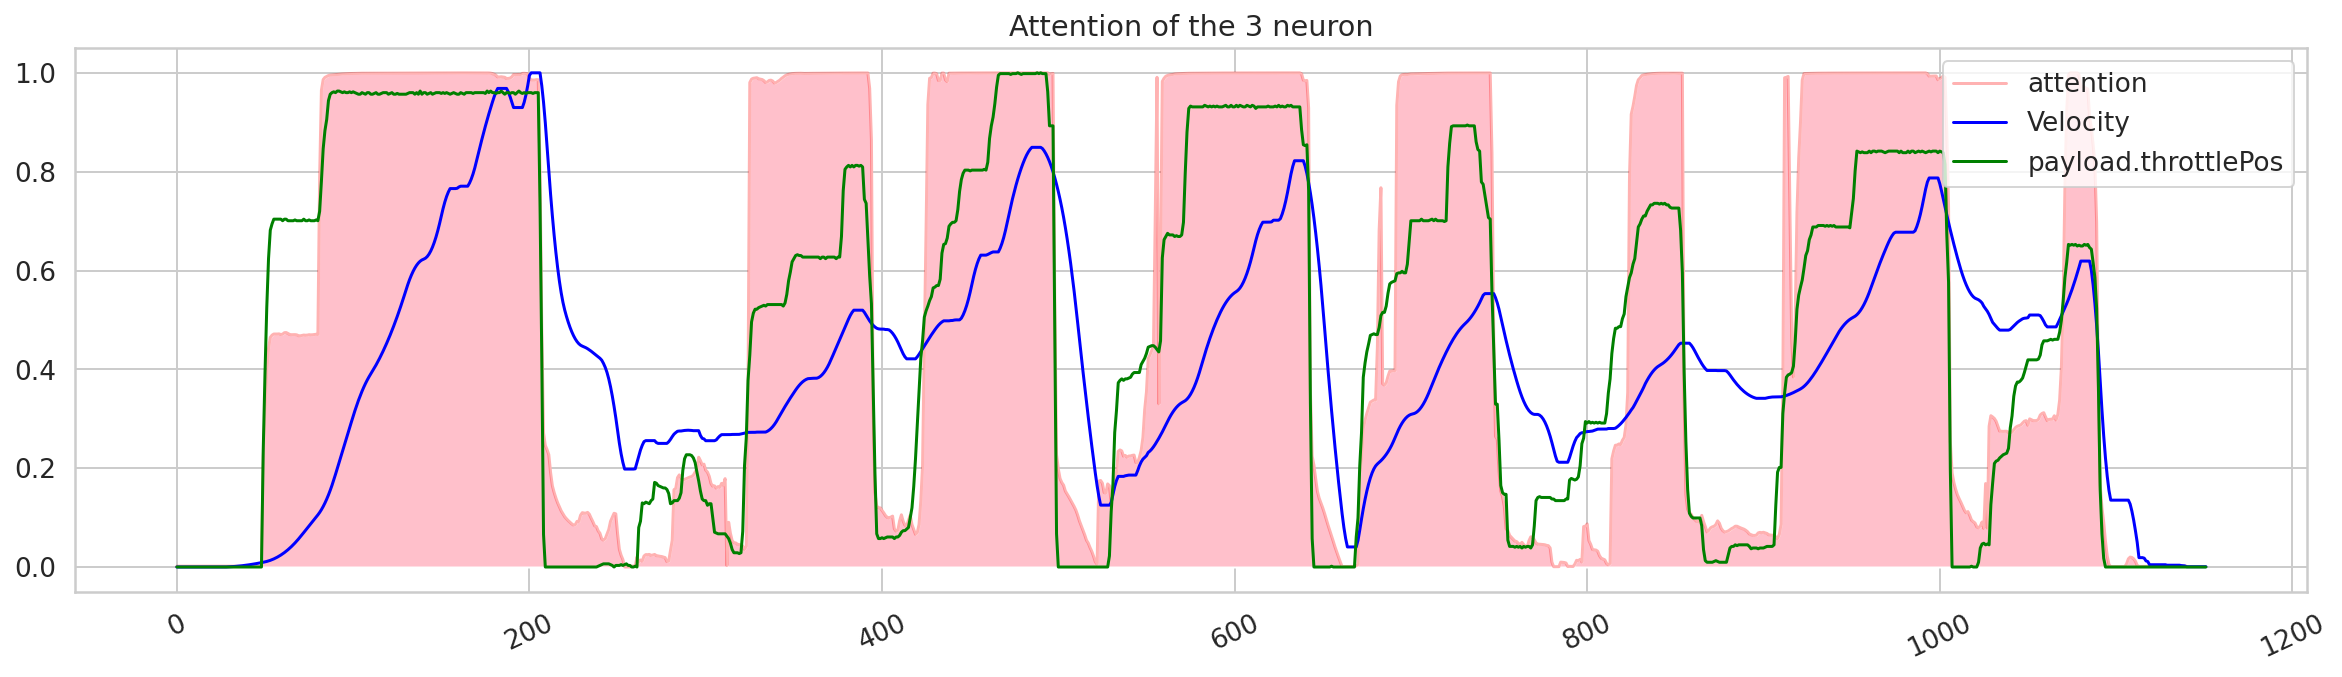

In [ ]:
  attention_norm , feature_1,feature_2  = plot_attention(driver=5,
               lap=2,
               neuron=2,
               f1=0, # Velocity
               f2= 6
               # throttlePos
               )

From the activation of the neuron 3, we can assume that this neuron is specialized into the extraction of the features related to aggressivity, which are :
  - High speed and positive acceleration.

  -  Pressure put on Throttle Position.

In [ ]:
list_acc_pos = []
a = np.array(lap_driver(5,2)["AT"][:1141])
for i in range(1141):
  if a[i] >0:
    list_acc_pos.append(a[i])
  else:
    list_acc_pos.append(0)

In [ ]:
len(list_acc_pos), attention_norm.shape

(1141, (1141, 1))

Text(0.5, 1.0, 'similarity between neuron 3 and Positive Acceleration')

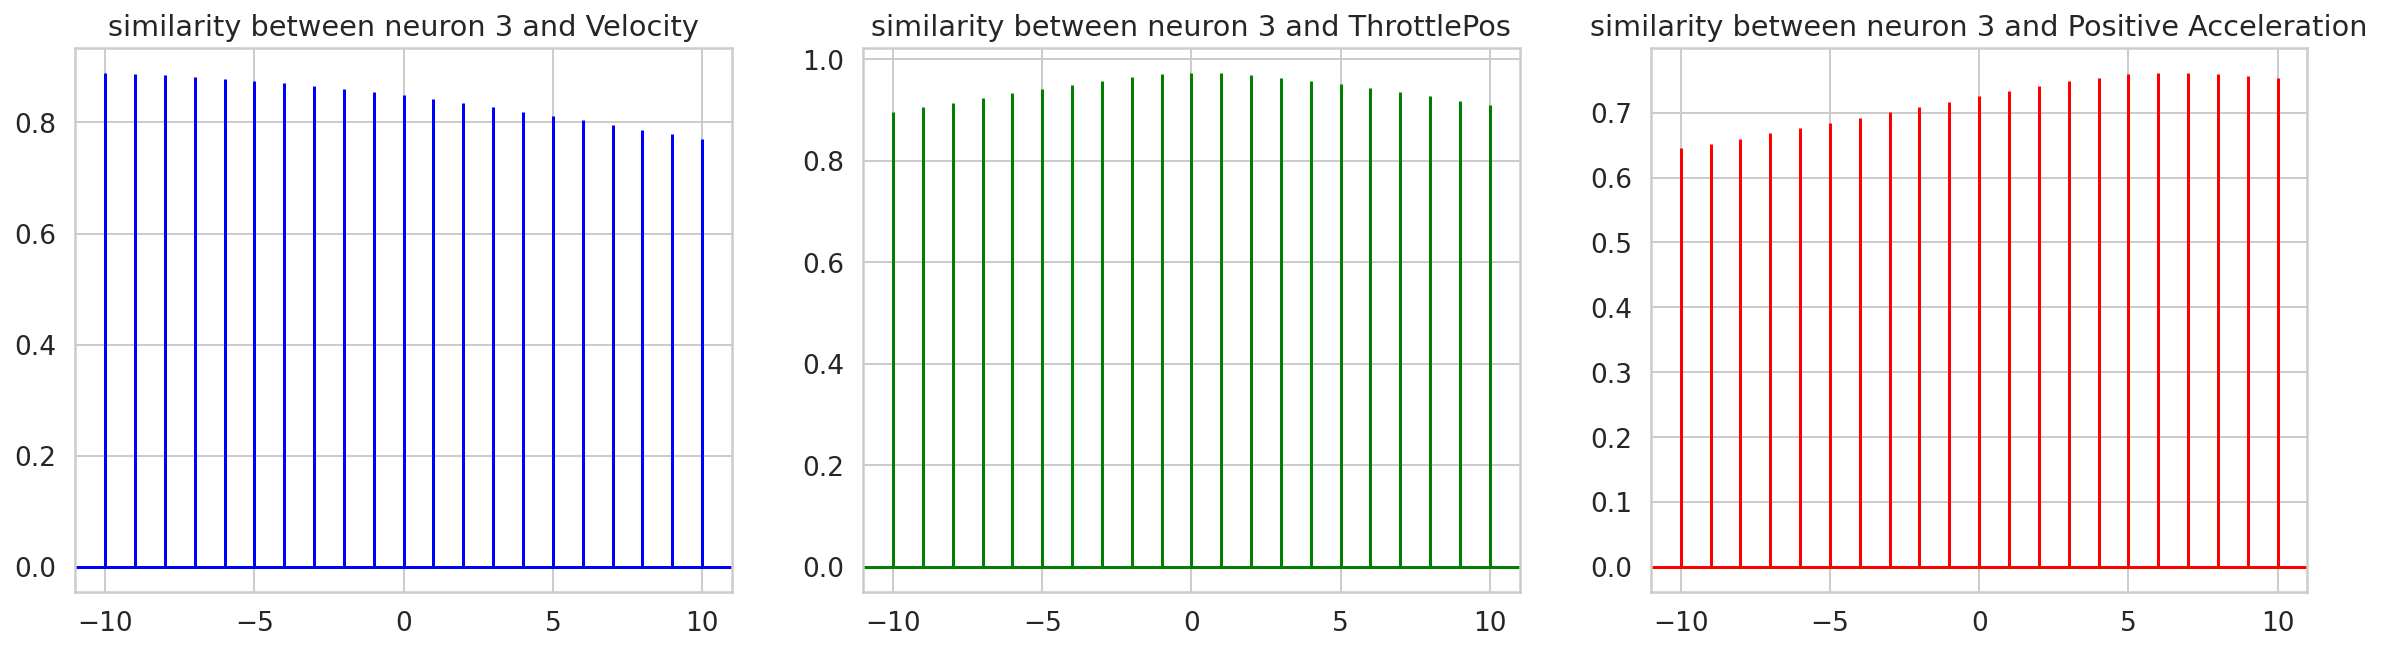

In [ ]:
fig,axes= plt.subplots(1,3,figsize=(20,5))

axes[0].xcorr(attention_norm.reshape(-1),feature_1.reshape(-1),color="blue",usevlines=True, normed=True)
axes[1].xcorr(attention_norm.reshape(-1),feature_2.reshape(-1),color="green",)
axes[2].xcorr(attention_norm.reshape(-1),list_acc_pos,color="red",)

axes[0].set_title("similarity between neuron 3 and Velocity")
axes[1].set_title("similarity between neuron 3 and ThrottlePos")
axes[2].set_title("similarity between neuron 3 and Positive Acceleration")



Cross-correlation computation in NumPy by matplotlib returns **correlation coefficients array** that represent degree of similarity of two datasets.

This cross correlation tells us that these the activation of this neuron and the features are  correlated.

In [ ]:
features_ = ["Velocity","AccelNcomp","Curvature","AT","payload.handleSteerPos",'payload.frontBrakePos','payload.throttlePos']
def plot_attention(driver,lap,neuron,f1,f2,f3,option="true"):
  # Recreate velocity for attention
  original,attention_data = attention_representation(driver,lap) # Driver 5 lap 3
  
  df_test = lap_driver(driver,lap)
  a= []
  for i in range(1141):
    a.append(attention_data[i,0,neuron])

  a = np.array(a)
  attention_norm = MinMaxScaler().fit_transform(np.array(a).reshape(-1,1))
  #attention_norm = np.array(a).reshape(-1,1)
  velocity_norm = MinMaxScaler().fit_transform(np.array(original))
  fig,axes = plt.subplots(figsize=(20,5))
  axes.plot(np.arange(0,len(a)),attention_norm,label= "attention",c='red',alpha=0.3)
  if option=="true":
    axes.plot(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f1],label=features_[f1],c="blue")
    axes.plot(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f2],label=features_[f2],c="green")
    axes.plot(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f3],label=features_[f3],c="purple")


  #axes.fill_between(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f1])
  #axes.fill_between(np.arange(0,velocity_norm.shape[0]),velocity_norm[:,f2])
  axes.fill_between(np.arange(0,len(a)),attention_norm.reshape(-1),facecolor="pink")

  plt.xticks(rotation=25)
  plt.legend()
  axes.set_title("Attention of the {} neuron".format(neuron +1))
  return attention_norm,velocity_norm[:attention_norm.shape[0],f1],velocity_norm[:attention_norm.shape[0],f2],velocity_norm[:attention_norm.shape[0],f3]

1152


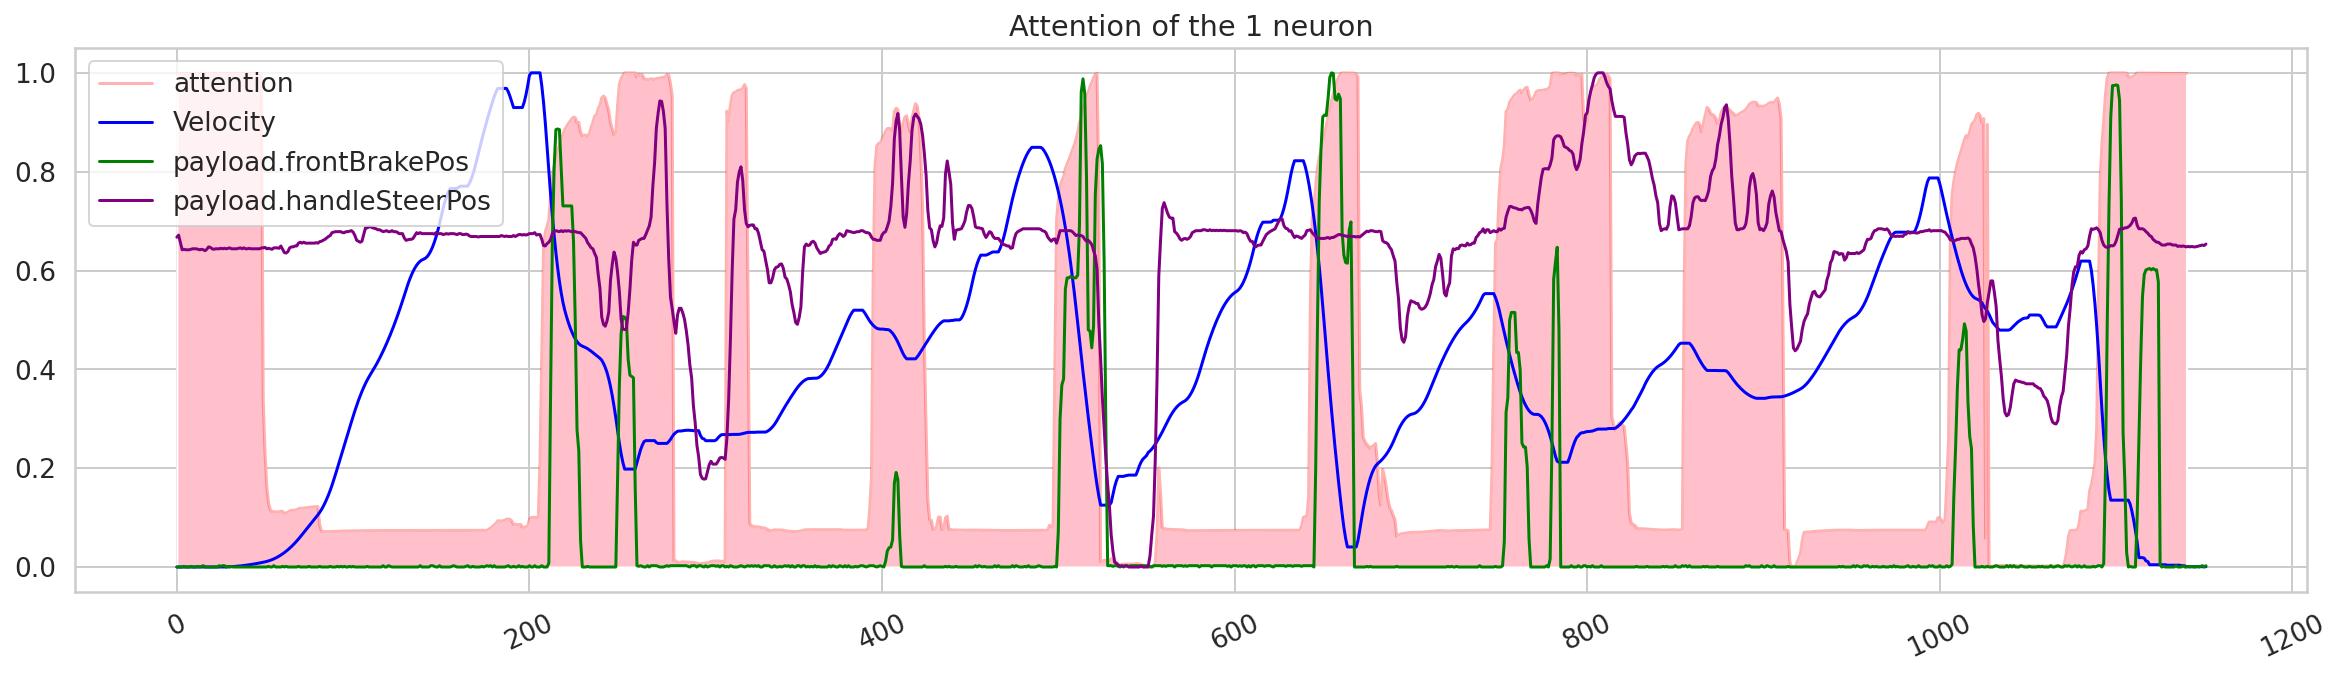

In [ ]:
  attention_norm , feature_1,feature_2,feature_3 = plot_attention(driver=5,
               lap=2,
               neuron=0,
               f1=0, # Velocity
               f2= 5,
               f3 = 4
               # throttlePos
               )

Text(0.5, 1.0, 'similarity between neuron 3 and Positive Acceleration')

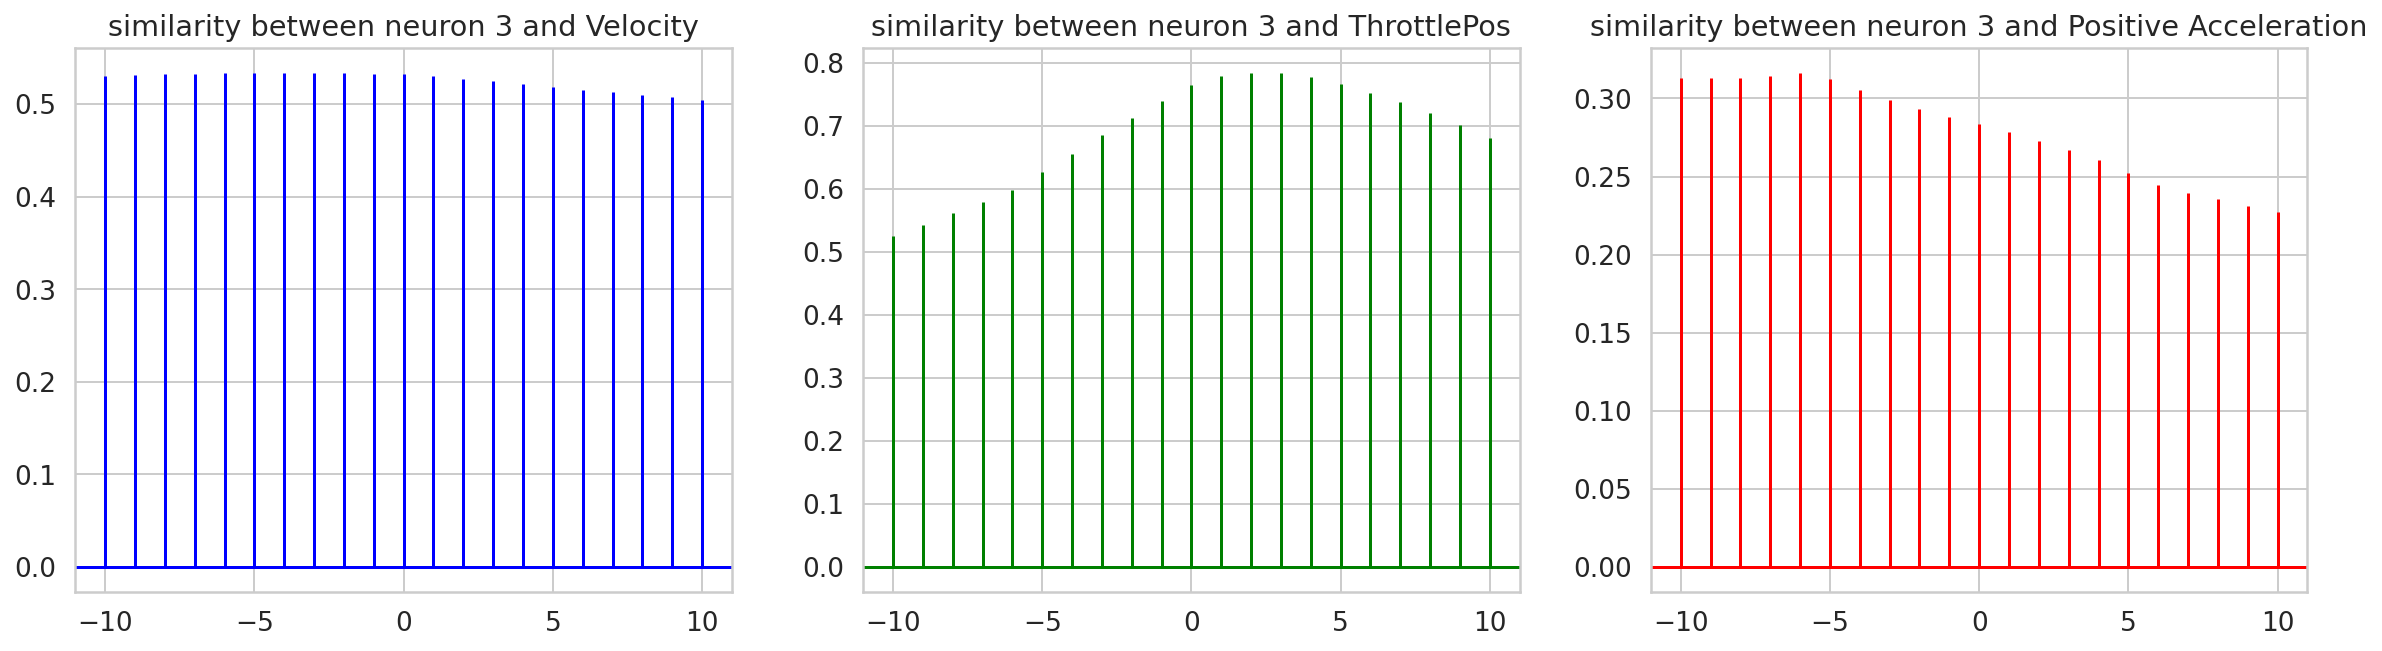

In [ ]:
fig,axes= plt.subplots(1,3,figsize=(20,5))

axes[0].xcorr(attention_norm.reshape(-1),feature_1.reshape(-1),color="blue",usevlines=True, normed=True)
axes[1].xcorr(attention_norm.reshape(-1),feature_2.reshape(-1),color="green",)
axes[2].xcorr(attention_norm.reshape(-1),list_acc_pos,color="red",)

axes[0].set_title("similarity between neuron 3 and Velocity")
axes[1].set_title("similarity between neuron 3 and ThrottlePos")
axes[2].set_title("similarity between neuron 3 and Positive Acceleration")



1152


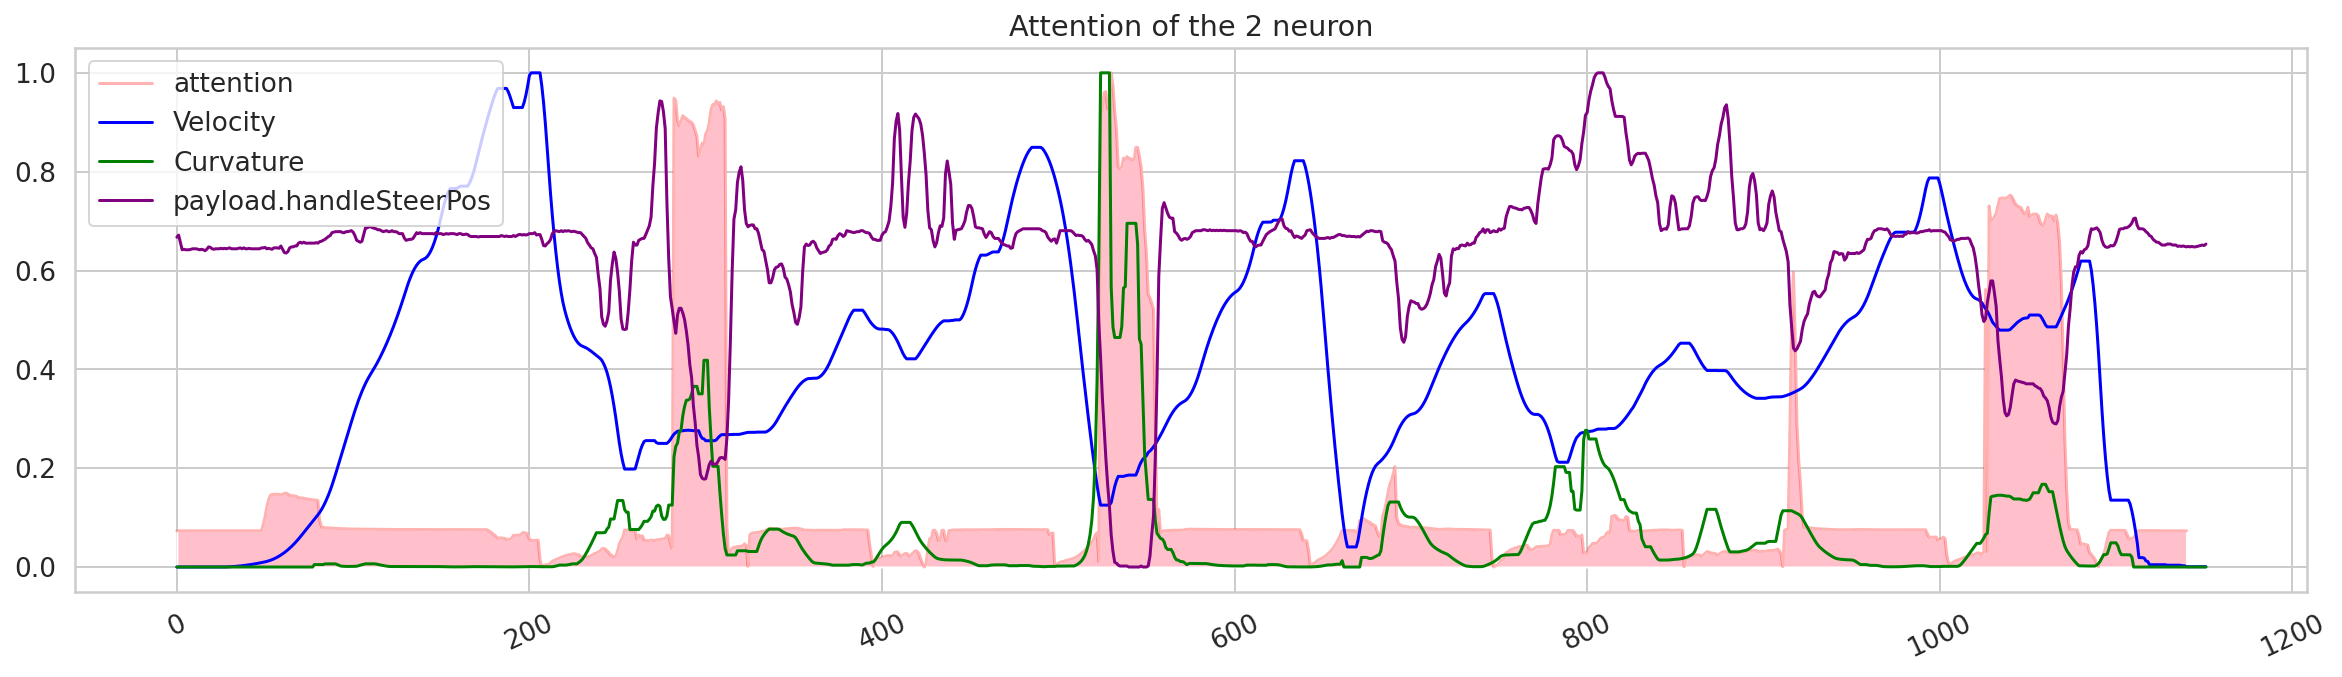

In [ ]:
  attention_norm , feature_1,feature_2,feature_3 = plot_attention(driver=5,
               lap=2,
               neuron=1,
               f1=0, # Velocity
               f2= 2,
               f3 = 4
               # throttlePos
               )

# Test on 48FBEE

In [ ]:
torch.save(model,"model_27janvier")

# Anomaly Detection

In [ ]:
def visualize_anomalies(data,labels,range_):
    labels = list(labels)
    plt.figure(figsize=(20,10))
    PtsList = data.values
    XYpts = PtsList[0:-3+1,[1, 0]]
    XYpts = XYpts[:range_]
    plt.scatter(XYpts[:len(labels),1],XYpts[:len(labels),0],c=labels,linewidth=0.5,cmap="inferno")
    
    plt.title("LAP  OF THE TEST DATASET")
    plt.show()





def mse_feature_evaluation(driver,lap,f):
  test = lap_driver(driver,lap)
  test_normalized = calc_TimeWindowedData(test, TimeWindow, col_use, speed_col_index)
  test_normalized_seq = create_sequences(test_normalized,10)
  test_torch = model.to_torch(test_normalized_seq).to(device)
  test_reconstructed = model(test_torch).detach().cpu().numpy()

  mse_loss = np.power(test_reconstructed[:,:,f] - test_normalized_seq[:,:,f],2)
  #plt.figure(figsize=(20,5))
  #sns.distplot(mse_loss, bins=50, kde=True);

  return test_normalized,np.mean(mse_loss,axis=1)

# MSE  global distribution

# Visualize anomalies of reconstruction on every features

In [ ]:
df_train_s.iloc[:,features_].columns

Index(['Velocity', 'AccelNcomp', 'Curvature', 'AT', 'payload.handleSteerPos',
       'payload.frontBrakePos', 'payload.throttlePos'],
      dtype='object')

In [ ]:
features_ = ["Velocity","AccelNcomp","Curvature","AT","payload.handleSteerPos",'payload.frontBrakePos','payload.throttlePos']


In [ ]:
import plotly.express as px
import pandas as pd
def anomaly_features(d,l):
  _,velocity_mse = mse_feature_evaluation(d,l,0)
  _,accelNcomp_mse = mse_feature_evaluation(d,l,1)
  _,curvature_mse = mse_feature_evaluation(d,l,2)
  _,handleSteerPos_mse = mse_feature_evaluation(d,l,4)
  _,frontBrakePos_mse = mse_feature_evaluation(d,l,5)
  _,throttlePos_mse = mse_feature_evaluation(d,l,6)
  _,AT_mse = mse_feature_evaluation(d,l,3)
  
  velocity_mse = np.mean(velocity_mse,0)
  accelNcomp_mse = np.mean(accelNcomp_mse,0)
  curvature_mse = np.mean(curvature_mse,0)
  handleSteerPos_mse = np.mean(handleSteerPos_mse,0)
  frontBrakePos_mse = np.mean(frontBrakePos_mse,0)
  throttlePos_mse = np.mean(throttlePos_mse,0)
  AT_mse = np.mean(AT_mse,0)

  df = pd.DataFrame(dict(
      r=[velocity_mse, accelNcomp_mse, curvature_mse, handleSteerPos_mse, frontBrakePos_mse,throttlePos_mse,AT_mse],
      theta=['velocity','accelNcomp ','curvature','handleSteerPos','frontBrakePos','throttlePos','AT']))
  fig = px.line_polar(df, r='r', theta='theta', line_close=True)
  fig.update_traces(fill='toself')
  fig.show()

def visualize_anomalies(data,labels,range_):
    labels = list(labels)
    plt.figure(figsize=(20,10))
    PtsList = data.values
    XYpts = PtsList[0:-3+1,[1, 0]]
    XYpts = XYpts[:range_]
    labels_hex = []
    for i in range(len(labels)):
      if labels[i] ==False:
        labels_hex.append("#CCFFCC")
      else:
        labels_hex.append("#0000FF")

    plt.scatter(XYpts[:len(labels),1],XYpts[:len(labels),0],c=labels_hex,linewidth=0.5,cmap="inferno")

    plt.title("LAP  OF THE TEST DATASET")
    plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

def anomaly_features(d,l,l2,r):
  _,velocity_mse = mse_feature_evaluation(d,l,0)
  _,accelNcomp_mse = mse_feature_evaluation(d,l,1)
  _,curvature_mse = mse_feature_evaluation(d,l,2)
  _,handleSteerPos_mse = mse_feature_evaluation(d,l,4)
  _,frontBrakePos_mse = mse_feature_evaluation(d,l,5)
  _,throttlePos_mse = mse_feature_evaluation(d,l,6)
  _,AT_mse = mse_feature_evaluation(d,l,3)
  
  velocity_mse = np.mean(velocity_mse,0)
  accelNcomp_mse = np.mean(accelNcomp_mse,0)
  curvature_mse = np.mean(curvature_mse,0)
  handleSteerPos_mse = np.mean(handleSteerPos_mse,0)
  frontBrakePos_mse = np.mean(frontBrakePos_mse,0)
  throttlePos_mse = np.mean(throttlePos_mse,0)
  AT_mse = np.mean(AT_mse,0)


  _,velocity_mse_5 = mse_feature_evaluation(d,l2,0)
  _,accelNcomp_mse_5 = mse_feature_evaluation(d,l2,1)
  _,curvature_mse_5 = mse_feature_evaluation(d,l2,2)
  _,handleSteerPos_mse_5 = mse_feature_evaluation(d,l2,4)
  _,frontBrakePos_mse_5 = mse_feature_evaluation(d,l2,5)
  _,throttlePos_mse_5 = mse_feature_evaluation(d,l2,6)
  _,AT_mse_5 = mse_feature_evaluation(d,l2,3)
  
  velocity_mse_5 = np.mean(velocity_mse_5,0)
  accelNcomp_mse_5 = np.mean(accelNcomp_mse_5,0)
  curvature_mse_5 = np.mean(curvature_mse_5,0)
  handleSteerPos_mse_5 = np.mean(handleSteerPos_mse_5,0)
  frontBrakePos_mse_5 = np.mean(frontBrakePos_mse_5,0)
  throttlePos_mse_5 = np.mean(throttlePos_mse_5,0)
  AT_mse_5 = np.mean(AT_mse_5,0)
  categories = ['velocity','accelNcomp ','curvature','handleSteerPos','frontBrakePos','throttlePos','AT']

  fig = go.Figure()

  fig.add_trace(go.Scatterpolar(
        r=[velocity_mse, accelNcomp_mse, curvature_mse, handleSteerPos_mse, frontBrakePos_mse,throttlePos_mse,AT_mse],
        theta=categories,
        fill='toself',
        name="lap {}".format(l+1)
  ))
  fig.add_trace(go.Scatterpolar(
        r=[velocity_mse_5, accelNcomp_mse_5, curvature_mse_5, handleSteerPos_mse_5, frontBrakePos_mse_5,throttlePos_mse_5,AT_mse_5],
        theta=categories,
        fill='toself',
        name="lap {}".format(l2+1)
  ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[0, r]
      )),
    showlegend=True
  )

  fig.show()


In [ ]:
anomaly_features(5,2,5,r=0.09)

1152
1152
1152
1152
1152
1152
1152
989
989
989
989
989
989
989


In [ ]:
anomaly_features(5,4,5,r=0.09)

908
908
908
908
908
908
908
989
989
989
989
989
989
989


On peut observer que l'anomalie est caractérisée par l'excès de frontBrake et de throttle Pos en grande partie au niveau du lap 6.

De plus, dans le LAP 5 on voit que l'accélération est moins reconstruite qu'au niveau du lap 6 ,ce qui est caractérisée par le fait que l'on ait pas imposé de restrictions au niveau du lap 5, et donc que l'accélération soit au maximale, et donc considéré comme anomalie vu l'absence de panneaux par exemple

### Evalute the MSE Loss of B0AE19 lap 6

In [ ]:
def mse_global_evaluation(driver,lap):
  test = lap_driver(driver,lap)
  test_normalized = calc_TimeWindowedData(test, TimeWindow, col_use, speed_col_index)
  test_normalized_seq = create_sequences(test_normalized,5)
  test_torch = model.to_torch(test_normalized_seq).to(device)
  test_reconstructed = model(test_torch).detach().cpu().numpy()
  mse_loss = np.mean(np.power(test_reconstructed - test_normalized_seq,2) , axis=1)
  plt.figure(figsize=(20,5))
  sns.distplot(mse_loss, bins=50, kde=True);

  return test_normalized,np.mean(mse_loss,axis=1)

908


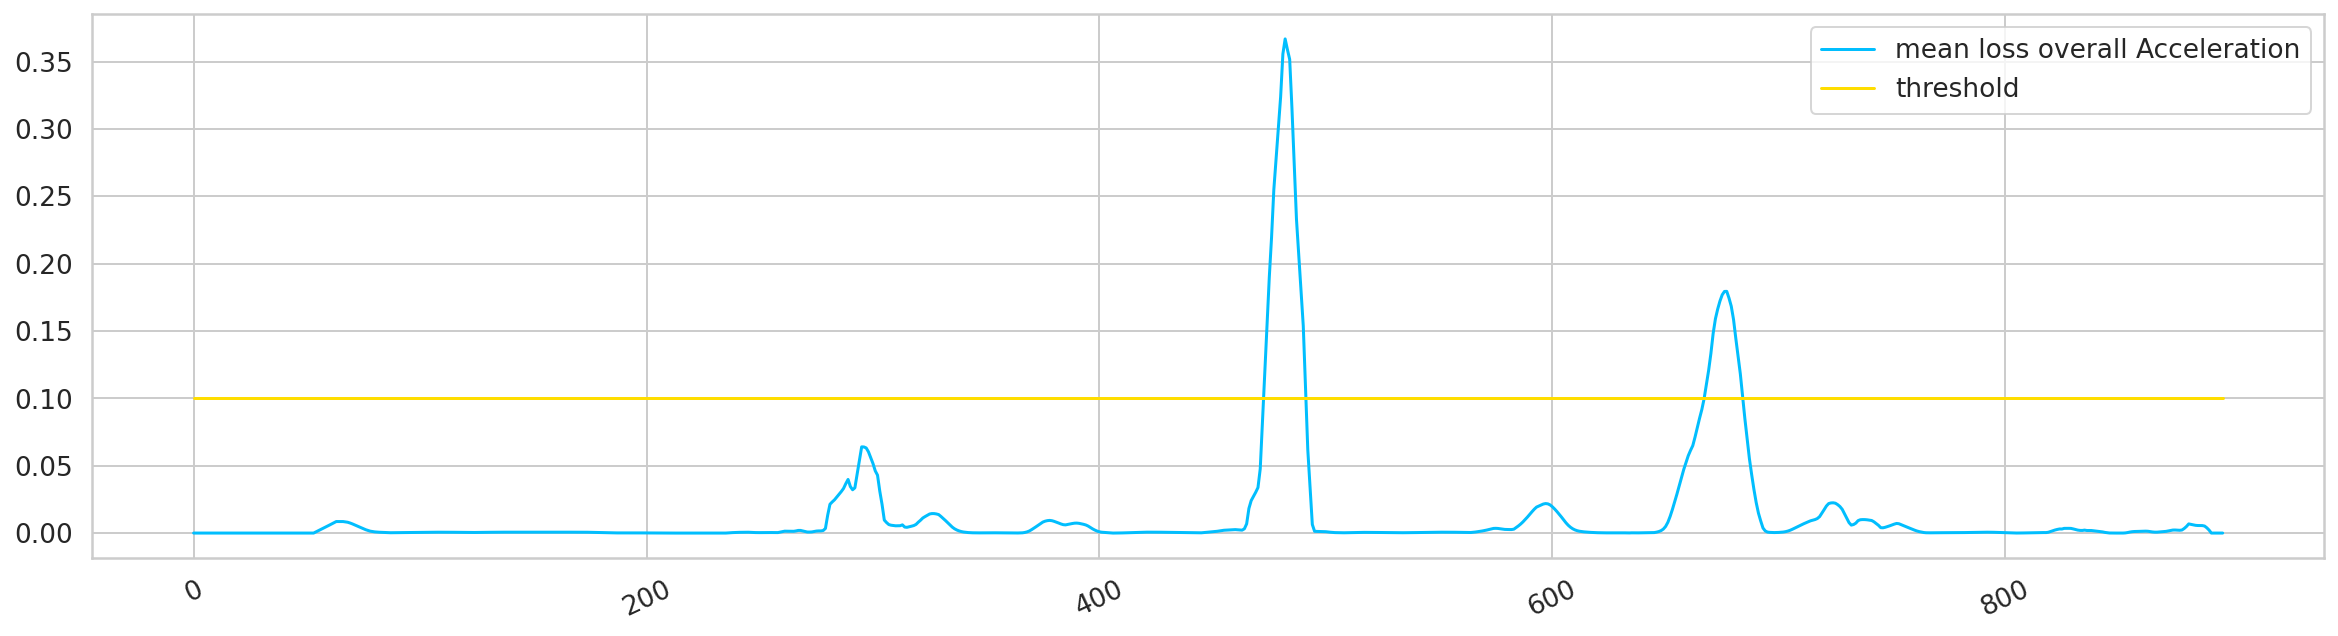

In [ ]:
driver,subject=5,4
test = lap_driver(driver,subject)
df_test = test
windowing_data,mse_loss = mse_feature_evaluation(driver,subject,2)
#windowing_data,mse_loss = mse_global_evaluation(driver,subject)


THRESHOLD = 0.1
test_score_df = pd.DataFrame()
test_score_df['loss'] = mse_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['velocity'] = np.array(windowing_data[:mse_loss.shape[0],0])
test_score_df['AccelNcomp'] = np.array(windowing_data[:mse_loss.shape[0],1])
test_score_df['Curvature'] = np.array(windowing_data[:mse_loss.shape[0],2])
test_score_df['payload.handleSteerPos'] = np.array(windowing_data[:mse_loss.shape[0],3])
test_score_df['payload.frontBrakePos'] = np.array(windowing_data[:mse_loss.shape[0],4])
test_score_df['payload.throttlePos'] = np.array(windowing_data[:mse_loss.shape[0],5])
test_score_df['AT'] = np.array(windowing_data[:mse_loss.shape[0],6])

plt.figure(figsize=(20,5))
plt.plot(test_score_df.index, test_score_df.loss, label='mean loss overall Acceleration')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

1161
1161


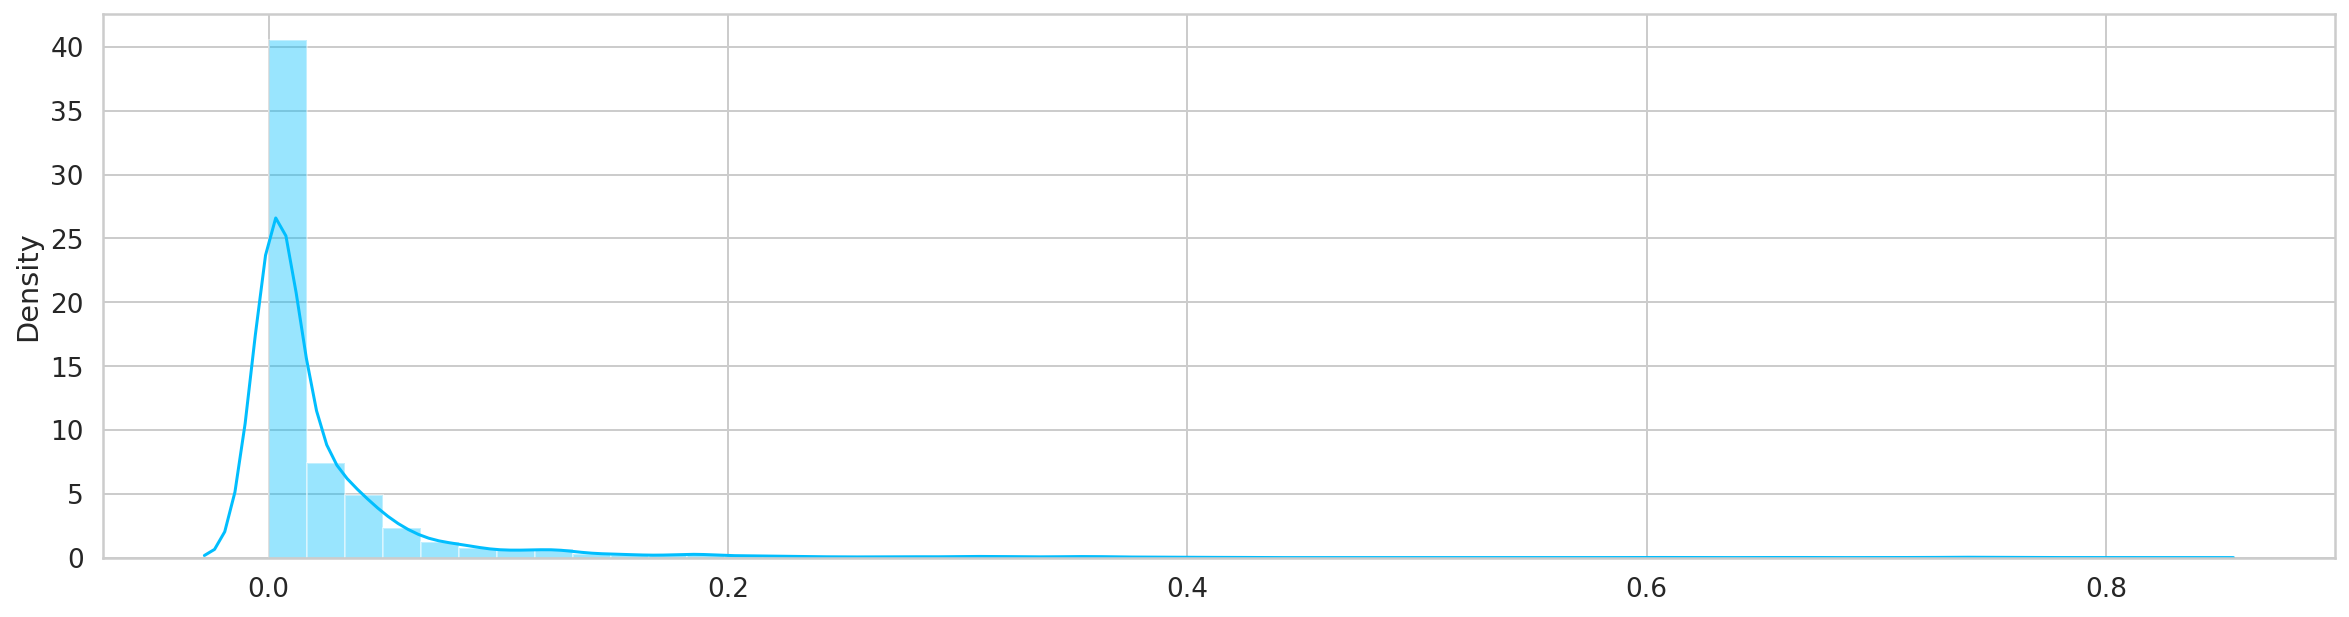

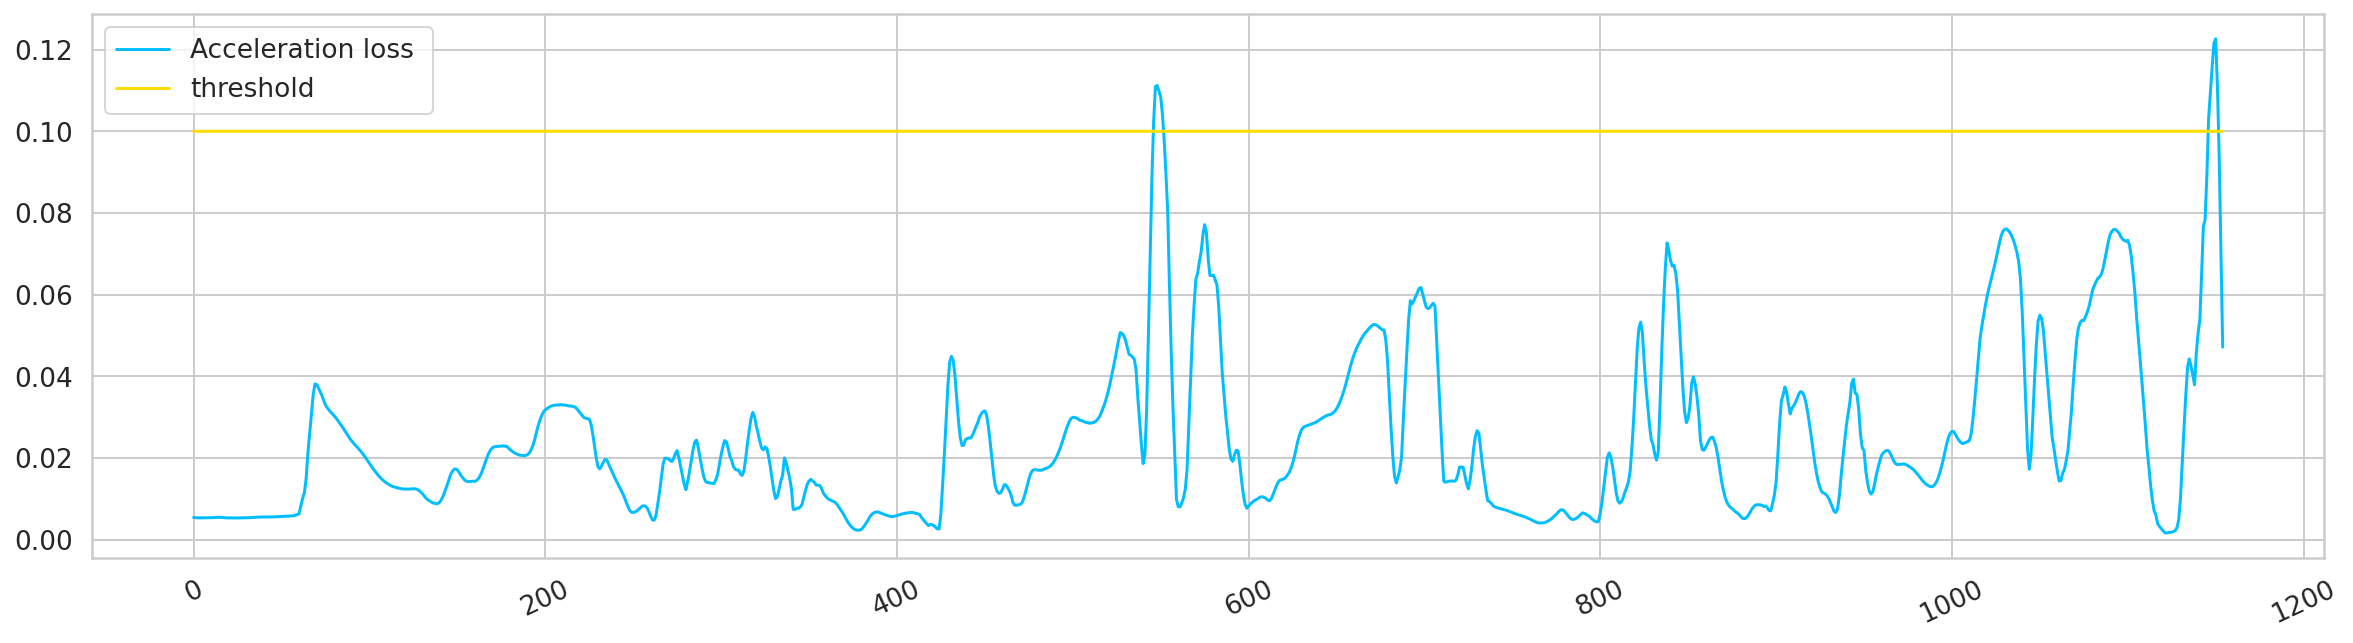

In [ ]:


plt.xticks(rotation=25)
plt.legend();





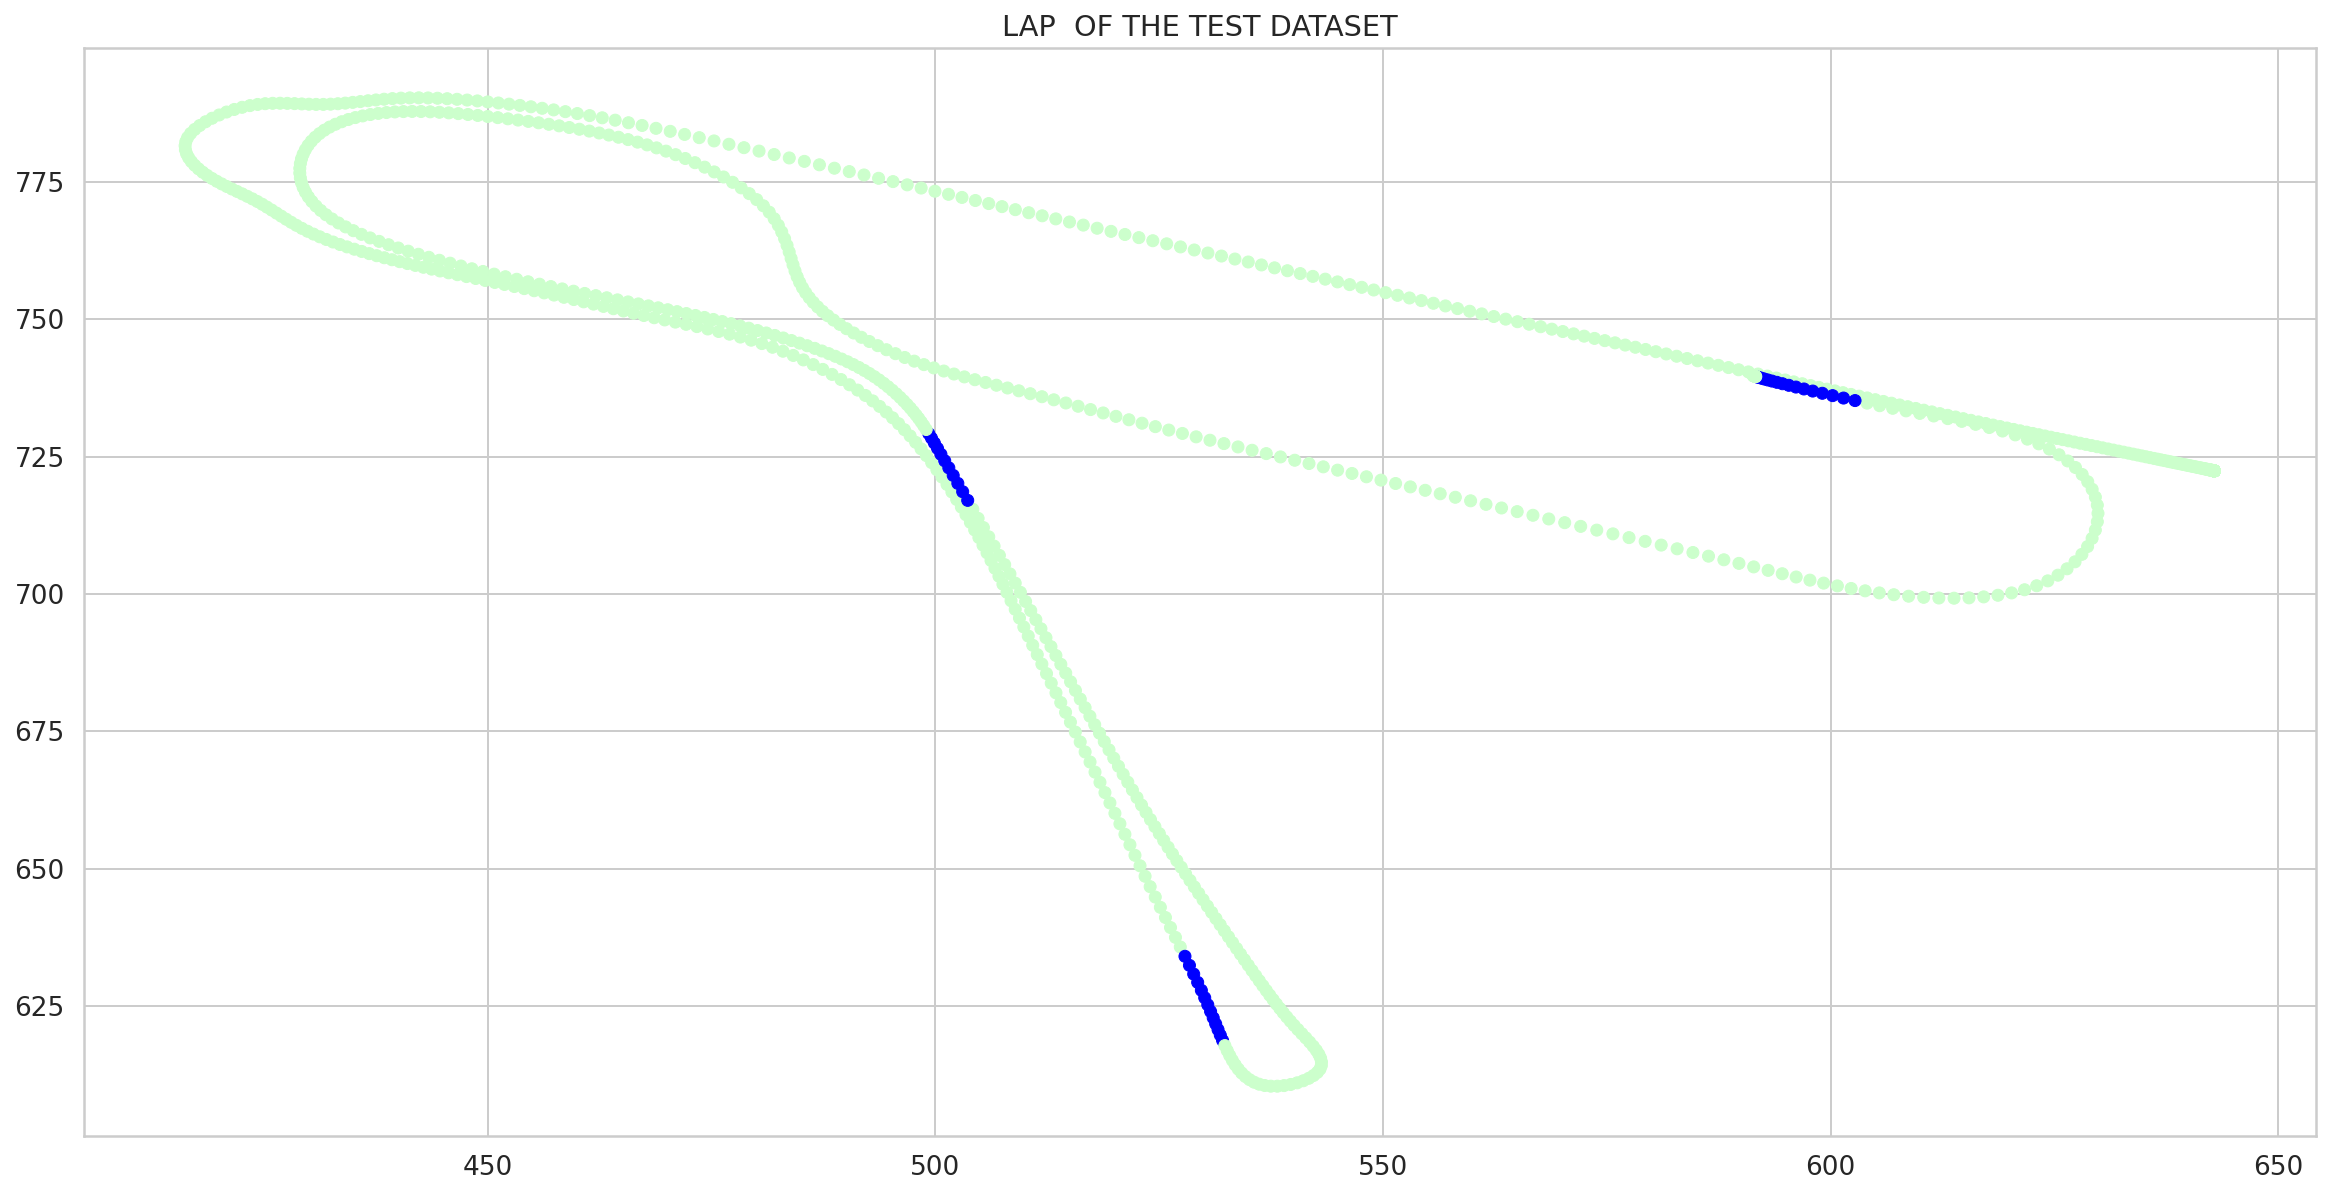

In [ ]:
from sklearn.preprocessing import MinMaxScaler
anomalies = test_score_df.copy()

scaler = MinMaxScaler()
scaler = scaler.fit(test[["Velocity"]])
velocity = scaler.inverse_transform(test_score_df[["velocity"]])
anomalies["velocity"]=velocity
test_score_df["lon"] = df_test["payload.Longitude"]
test_score_df["lat"] = df_test["payload.Latitude"]

visualize_anomalies(df_test,anomalies["anomaly"],test.shape[0])

In [ ]:
anomalies.loc[450:500]

### Plot the  Anomaly on the velocity profile

In [ ]:
def seq_loss(df_test,modell,f,seq_):
  windowing_data = calc_TimeWindowedData(df_test, TimeWindow, col_use, speed_col_index)
  test_data = create_sequences(windowing_data,5)
  testloader = torch.from_numpy(test_data).float()
  fig, ax = plt.subplots(figsize=(20, 6))
  i= 0
  with torch.no_grad():
    model =modell.eval() 
    for seq in testloader[seq_:seq_+1]:
       # i+=1
        seq = seq.to(device)
        seq_true = seq.to(device)
        seq_pred = model.forward(seq_true.reshape(-1,5,7))
        #print(seq_pred[-1,:,f].shape, seq_true[:,f].shape)
        ax.plot(seq_true.detach().cpu().numpy()[:,f],c="b",label="true sequence")
        ax.plot(seq_pred.detach().cpu().numpy()[-1,:,f],c="r",label="reconstructed sequence")
        plt.legend();


        loss = torch.nn.CosineSimilarity(dim=0)(seq_pred[-1,:,f],seq_true[:,f])
        #loss = torch.nn.KLDivLoss()(seq_pred[-1,:,f],seq_true[:,f])

        print("Cosinus similarity between sequence is {}".format(loss))
       


## Project the anomaly on the LAP

In [ ]:
anomalies_velocity = anomalies[anomalies["anomaly"] == True] 
velocity = anomalies[anomalies["anomaly"] == False] 

In [ ]:
anomalies_list = anomalies.index[anomalies['anomaly'] == True].tolist()

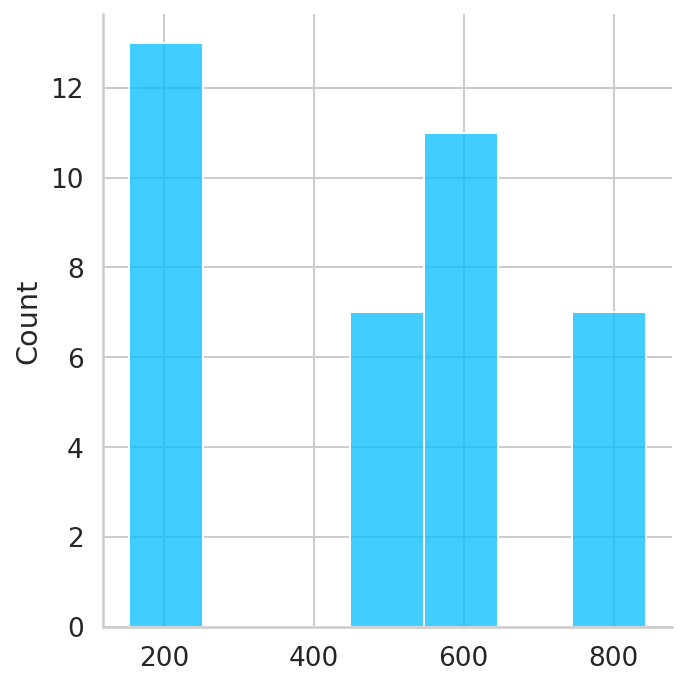

In [ ]:
sns.displot(anomalies_list)

sequence 47
989
Cosinus similarity between sequence is 0.9999829530715942


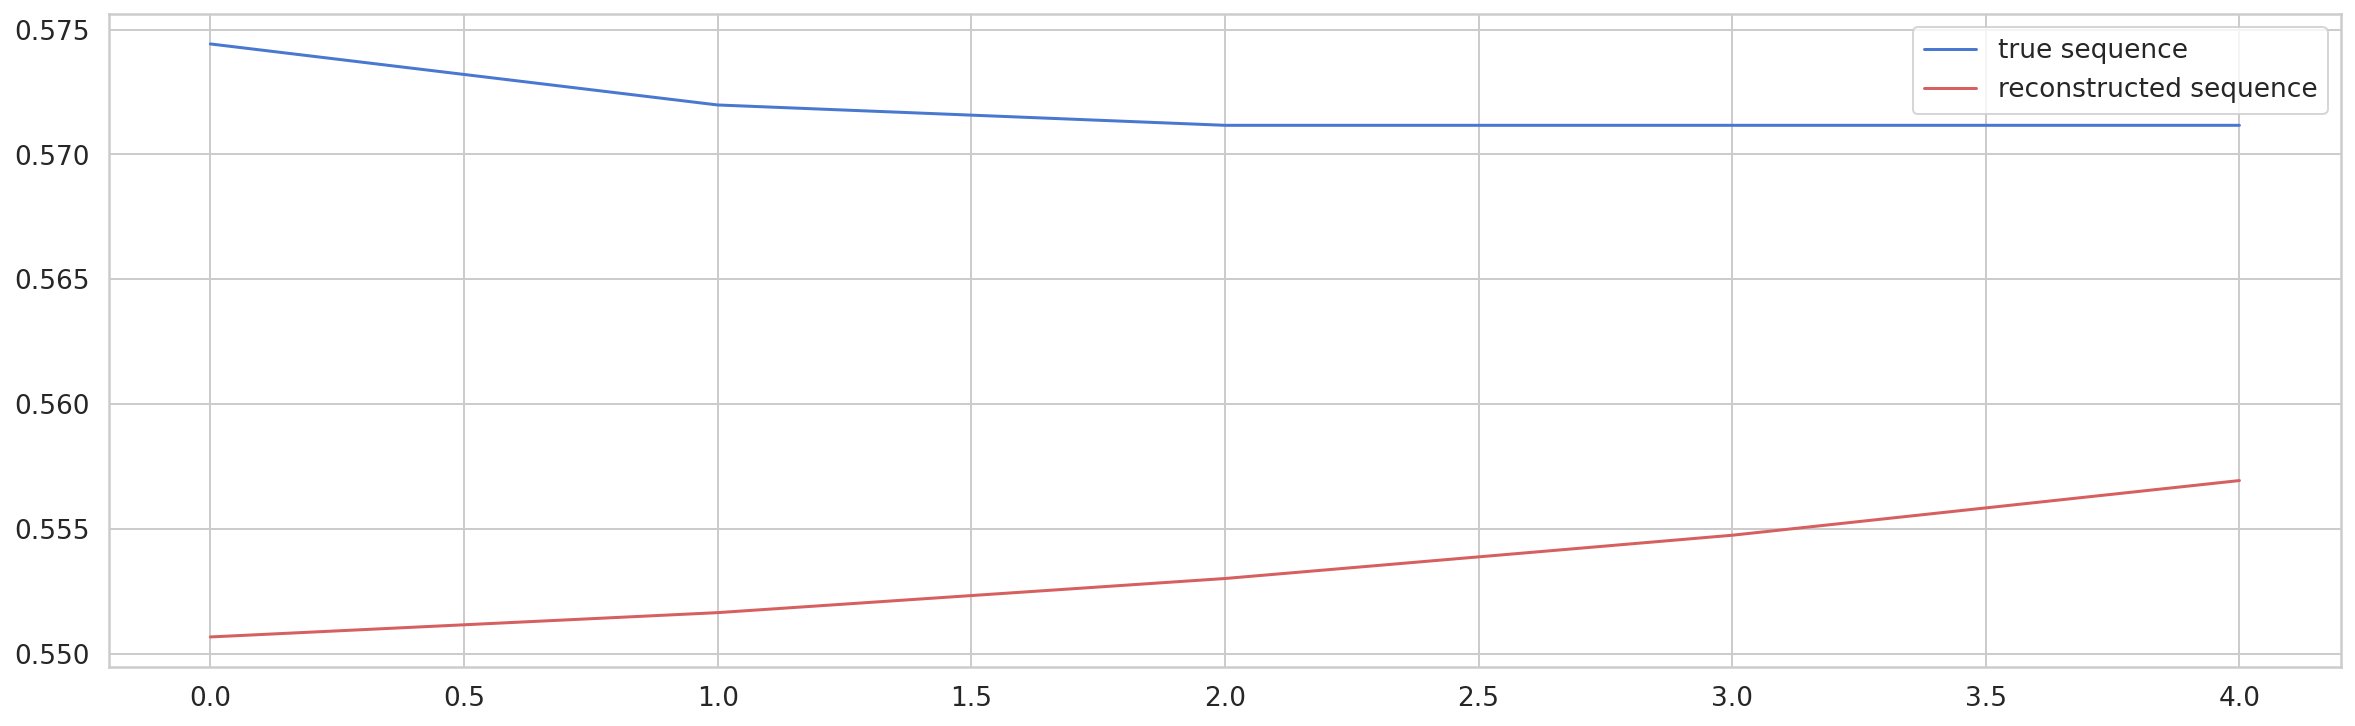

In [ ]:
print("sequence 47")
a = seq_loss(lap_driver(5,5),model,4,840)

In [ ]:
anomalies.shape , df_test.shape

((1140, 12), (1152, 14))

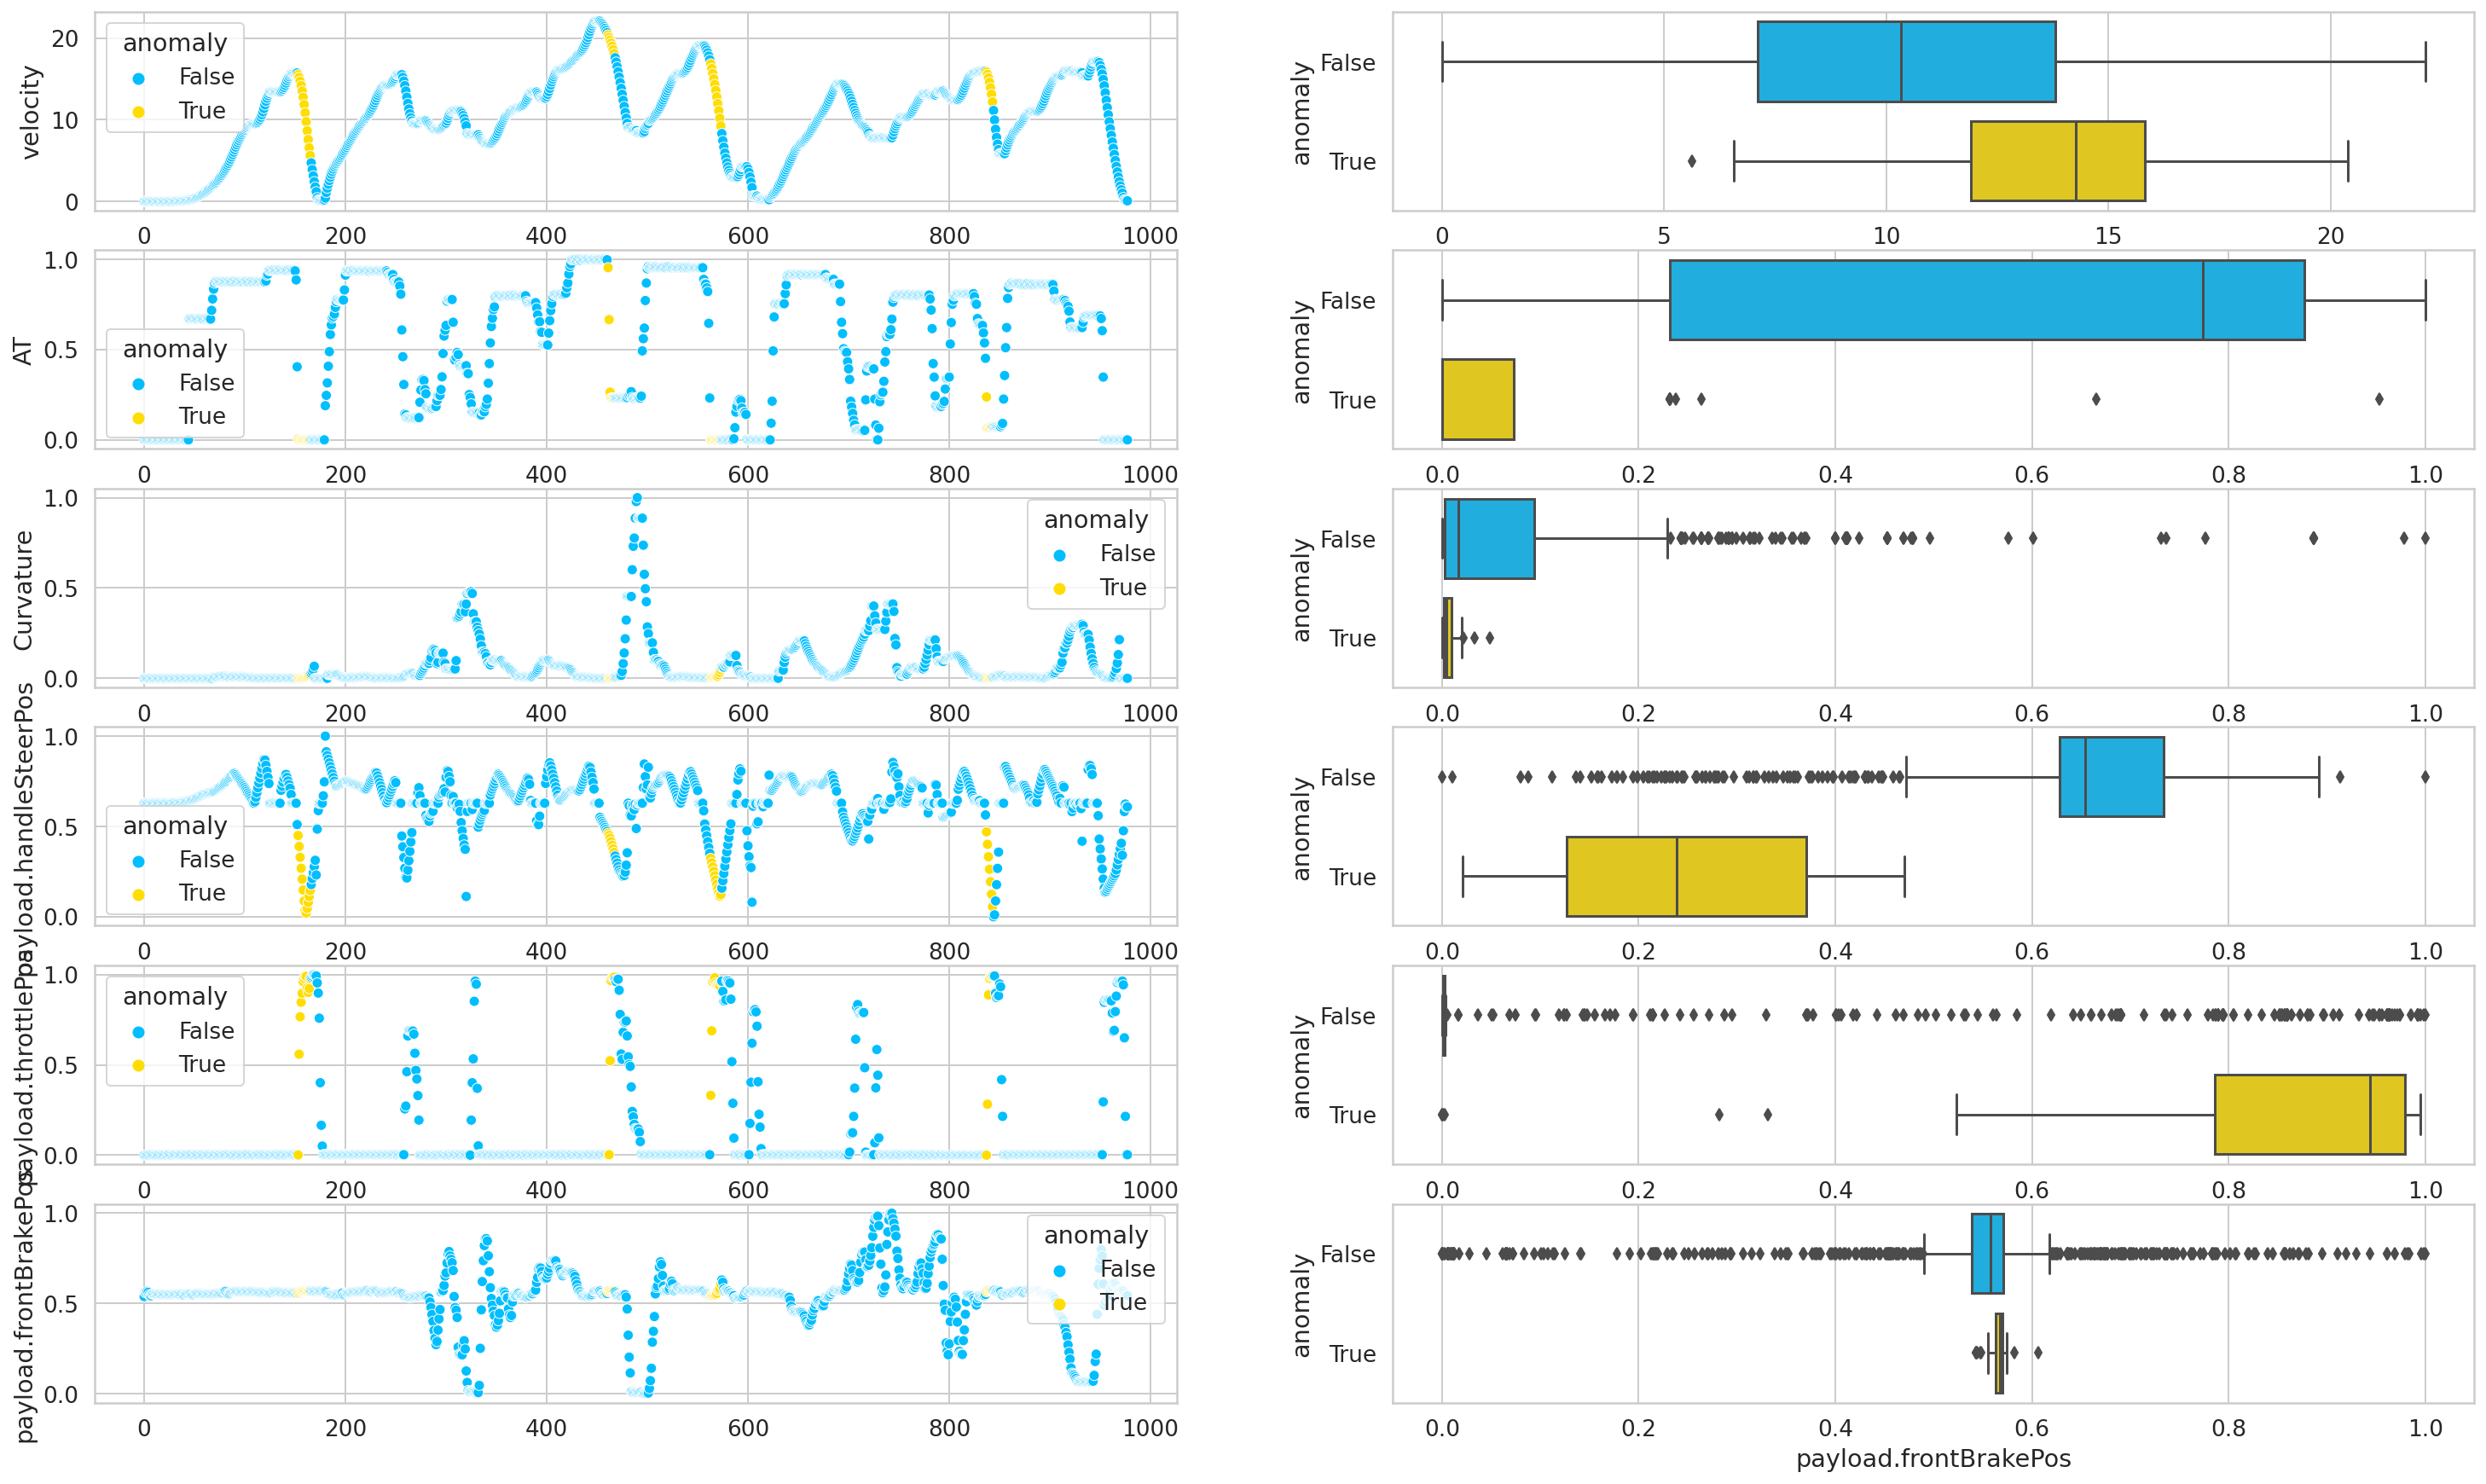

In [ ]:
fig,axes=plt.subplots(6,2, figsize=(25, 15))
sns.scatterplot(ax=axes[0,0],x=anomalies.index,y=anomalies["velocity"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[0,1],x="velocity", y="anomaly", data=anomalies,orient="h")

sns.scatterplot(ax=axes[1,0],x=anomalies.index,y=anomalies["AT"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[1,1],x="AT", y="anomaly", data=anomalies,orient="h")

sns.scatterplot(ax=axes[2,0],x=anomalies.index,y=anomalies["Curvature"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[2,1],x="Curvature", y="anomaly", data=anomalies,orient="h")

sns.scatterplot(ax=axes[3,0],x=anomalies.index,y=anomalies["payload.handleSteerPos"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[3,1],x="payload.handleSteerPos", y="anomaly", data=anomalies,orient="h")


sns.scatterplot(ax=axes[4,0],x=anomalies.index,y=anomalies["payload.throttlePos"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[4,1],x="payload.throttlePos", y="anomaly", data=anomalies,orient="h")


sns.scatterplot(ax=axes[5,0],x=anomalies.index,y=anomalies["payload.frontBrakePos"],hue=anomalies["anomaly"])
sns.boxplot(ax=axes[5,1],x="payload.frontBrakePos", y="anomaly", data=anomalies,orient="h")

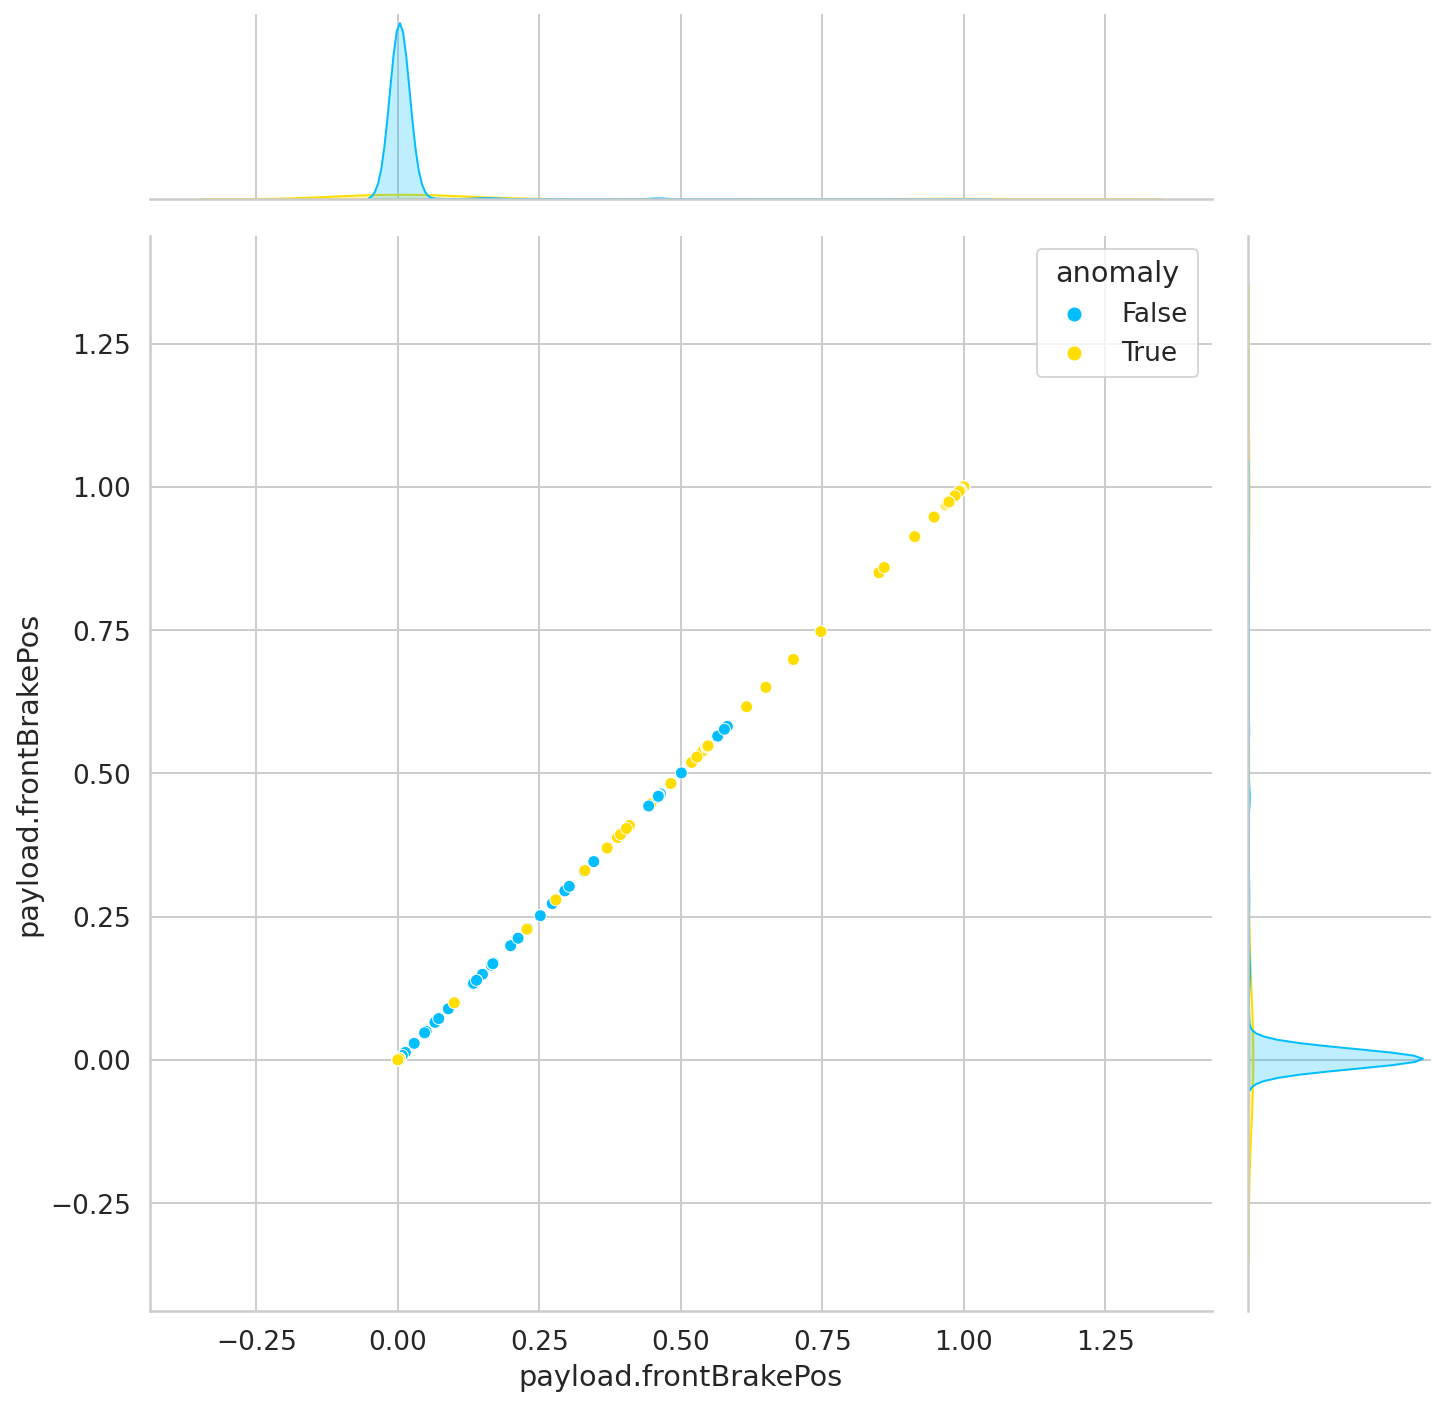

In [ ]:
sns.jointplot(x ="payload.frontBrakePos",y="payload.frontBrakePos",
              hue="anomaly",
              data = anomalies,height=10)
#sns.factorplot(ax=axes[2],x="anomaly", y="close_s", data=anomalies,kind="violin")

# Visualisation of the specialized neurons

# Acceleration

- Velocity = **0**

- AccelNcomp = **1**

- Curvature = **2**

- handleSteerPos = **3**

- frontBrakePos = **4**

- throttlePos = **5**

- AT = **6**


In [ ]:
[2,3,5,6,9,10,11]

[2, 3, 5, 6, 9, 10, 11]

1152


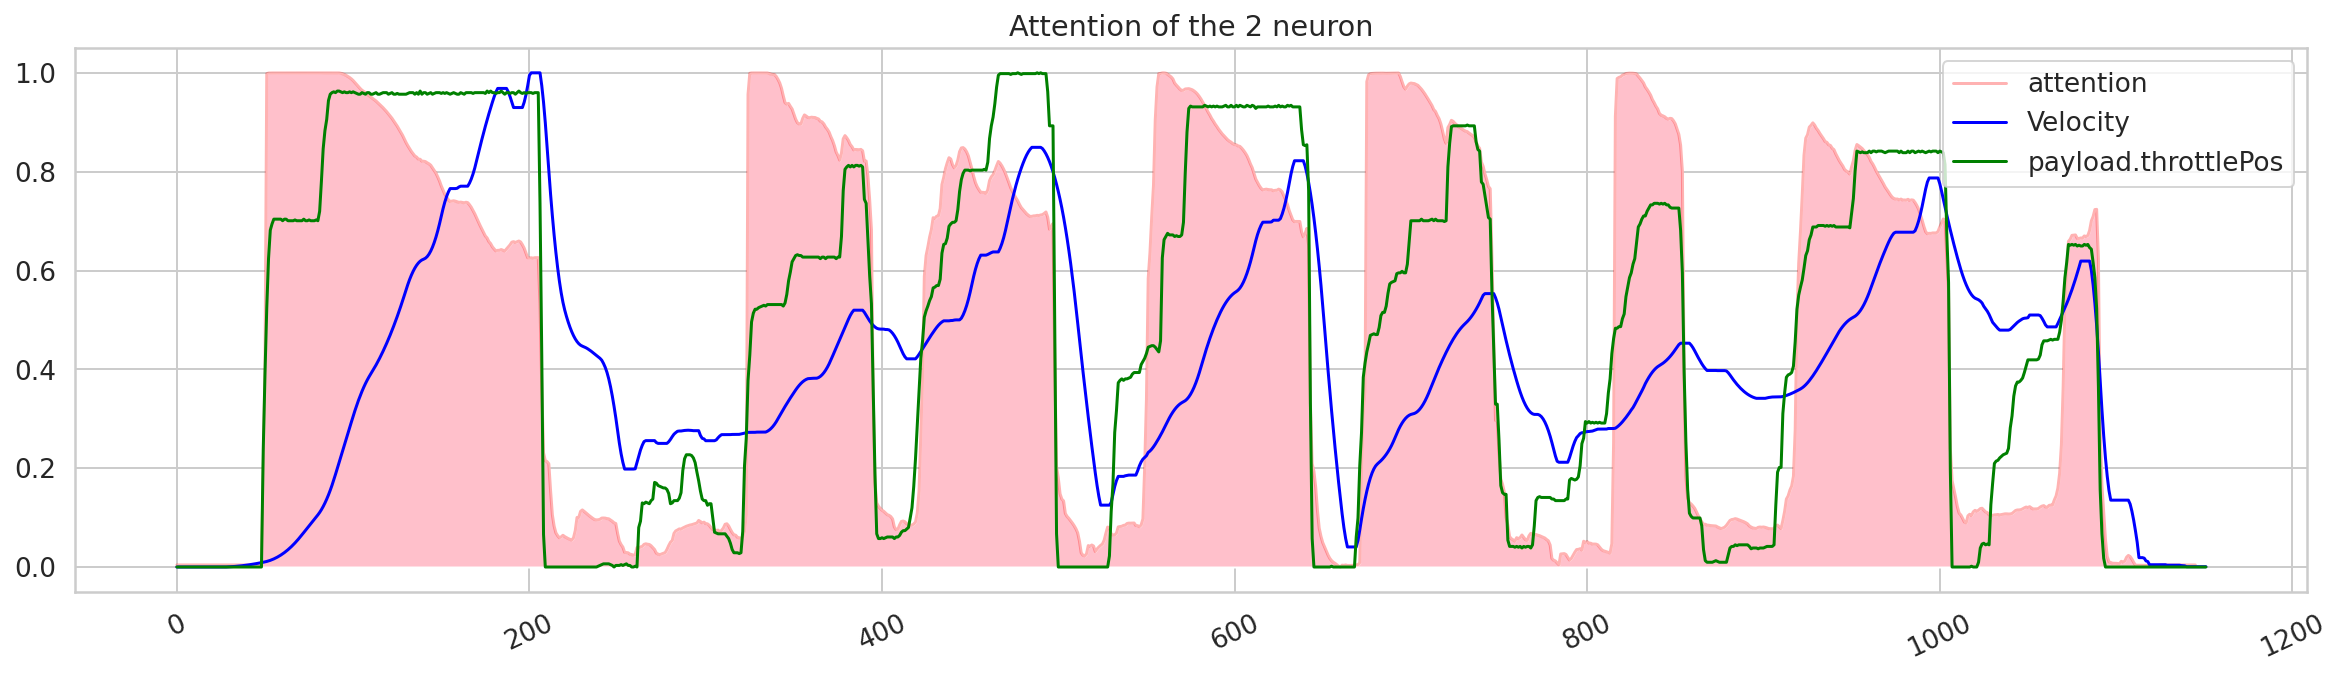

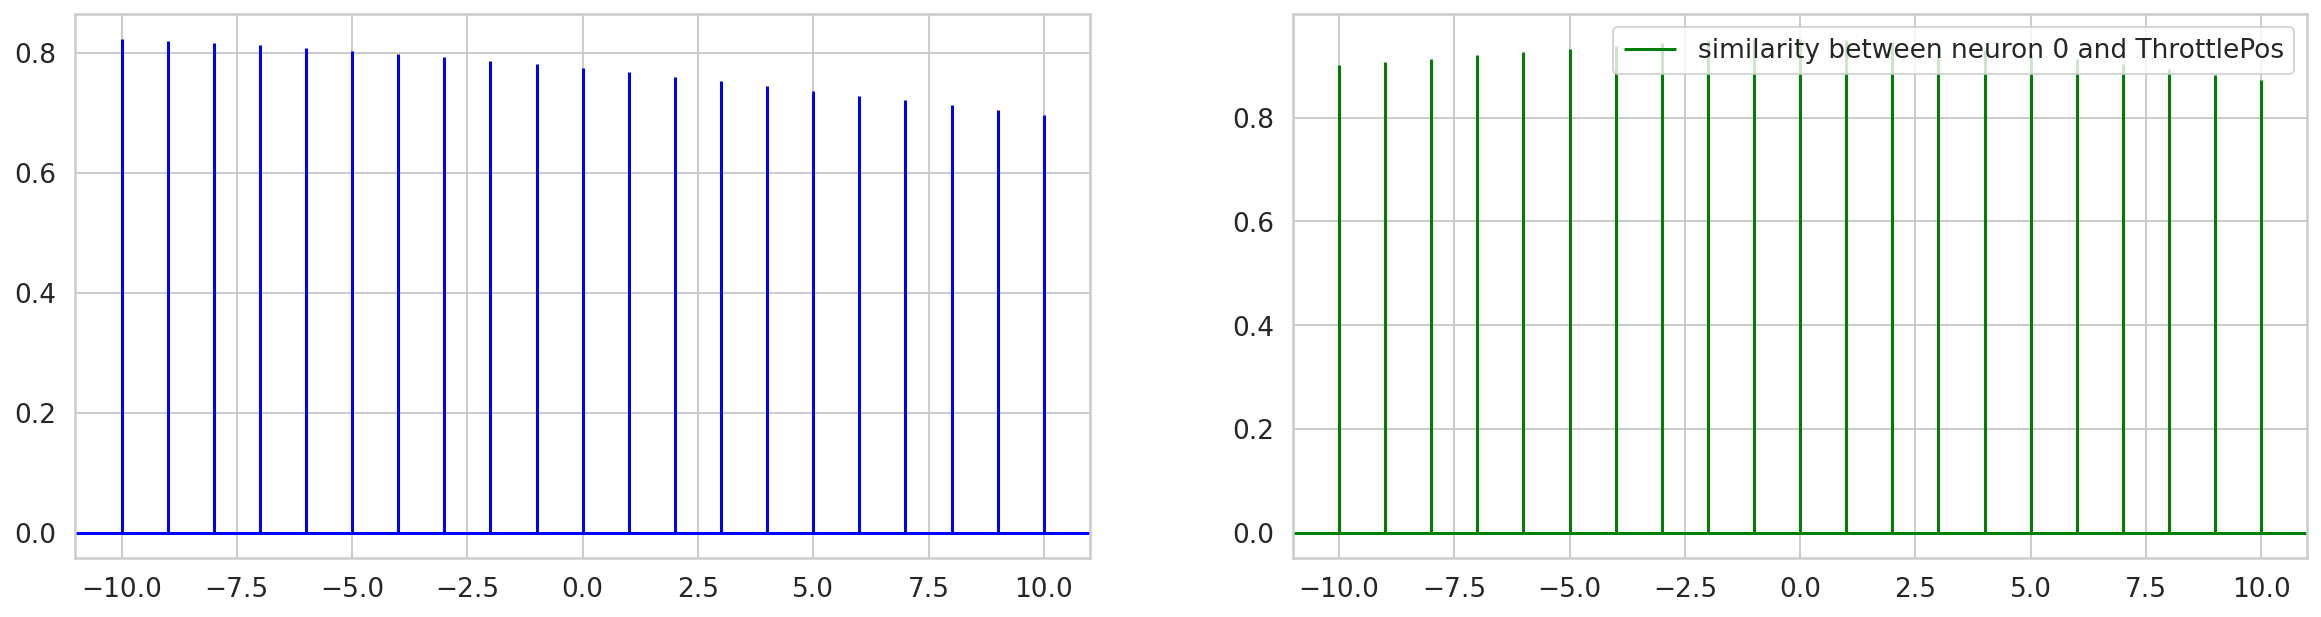

# Neuron 2

1152


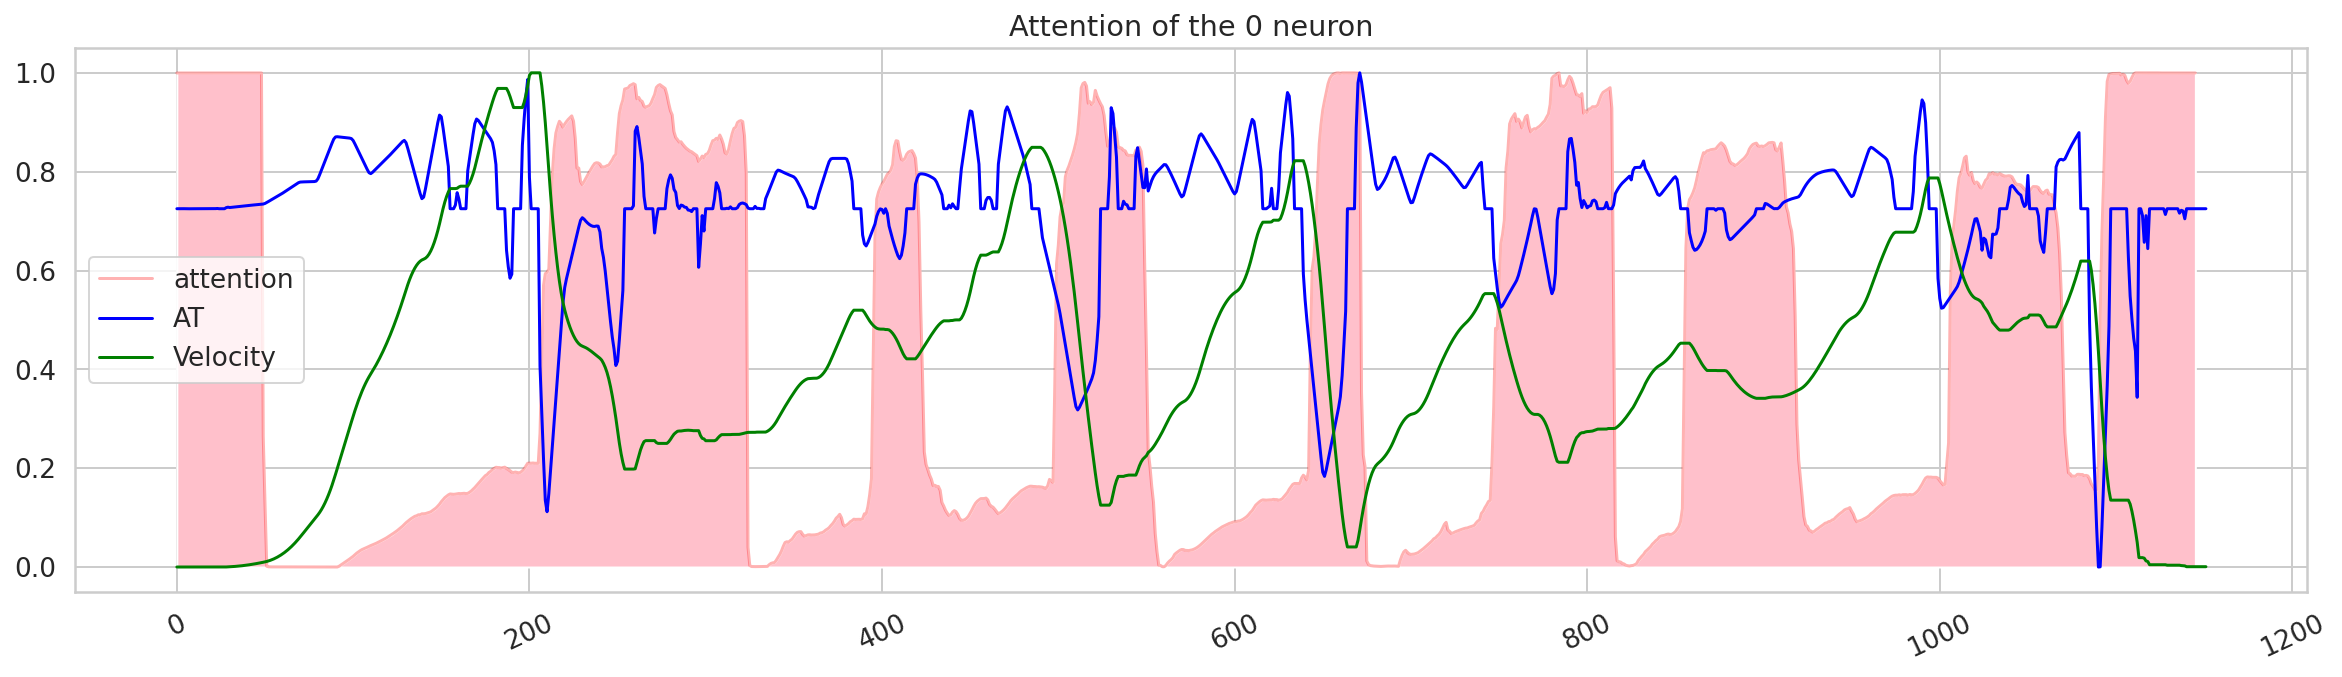

In [ ]:
  attention_norm_1 , feature_1,feature_2 = plot_attention(driver=5,
               lap=2,
               neuron=0,
               f1=3, # Velocity
               f2= 0 # throttlePos
               )

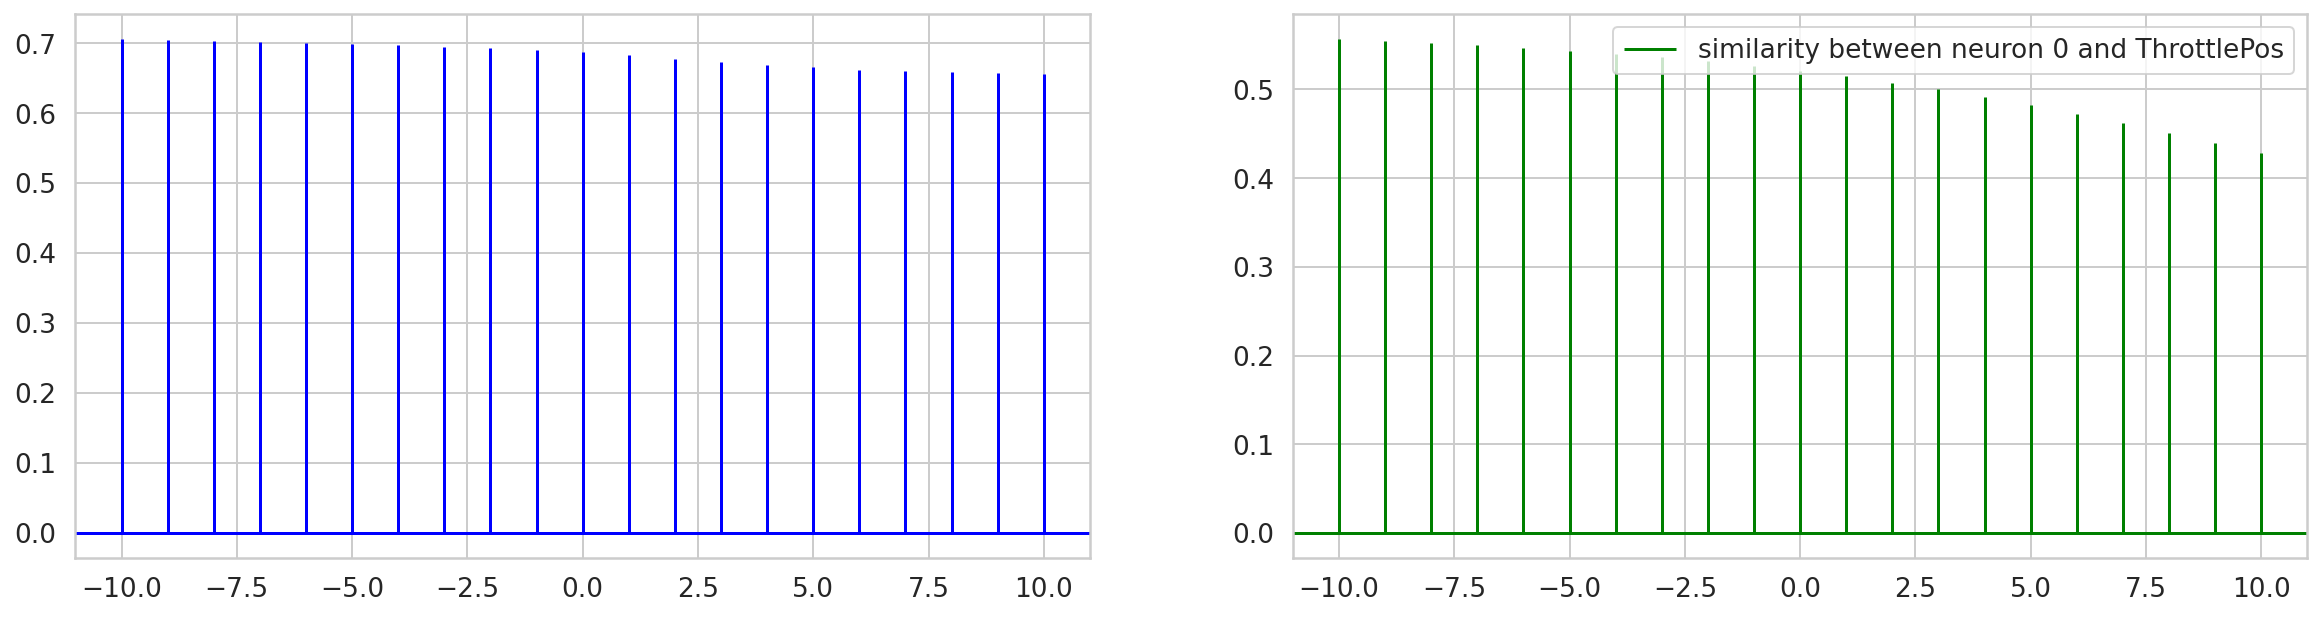

In [ ]:
fig,axes= plt.subplots(1,2,figsize=(20,5))
axes[0].xcorr(attention_norm_1.reshape(-1),feature_1,label="similarity between neuron 0 and Velocity",color="blue")
axes[1].xcorr(attention_norm_1.reshape(-1),feature_2.reshape(-1),label="similarity between neuron 0 and ThrottlePos",color="green")
plt.legend();

1152


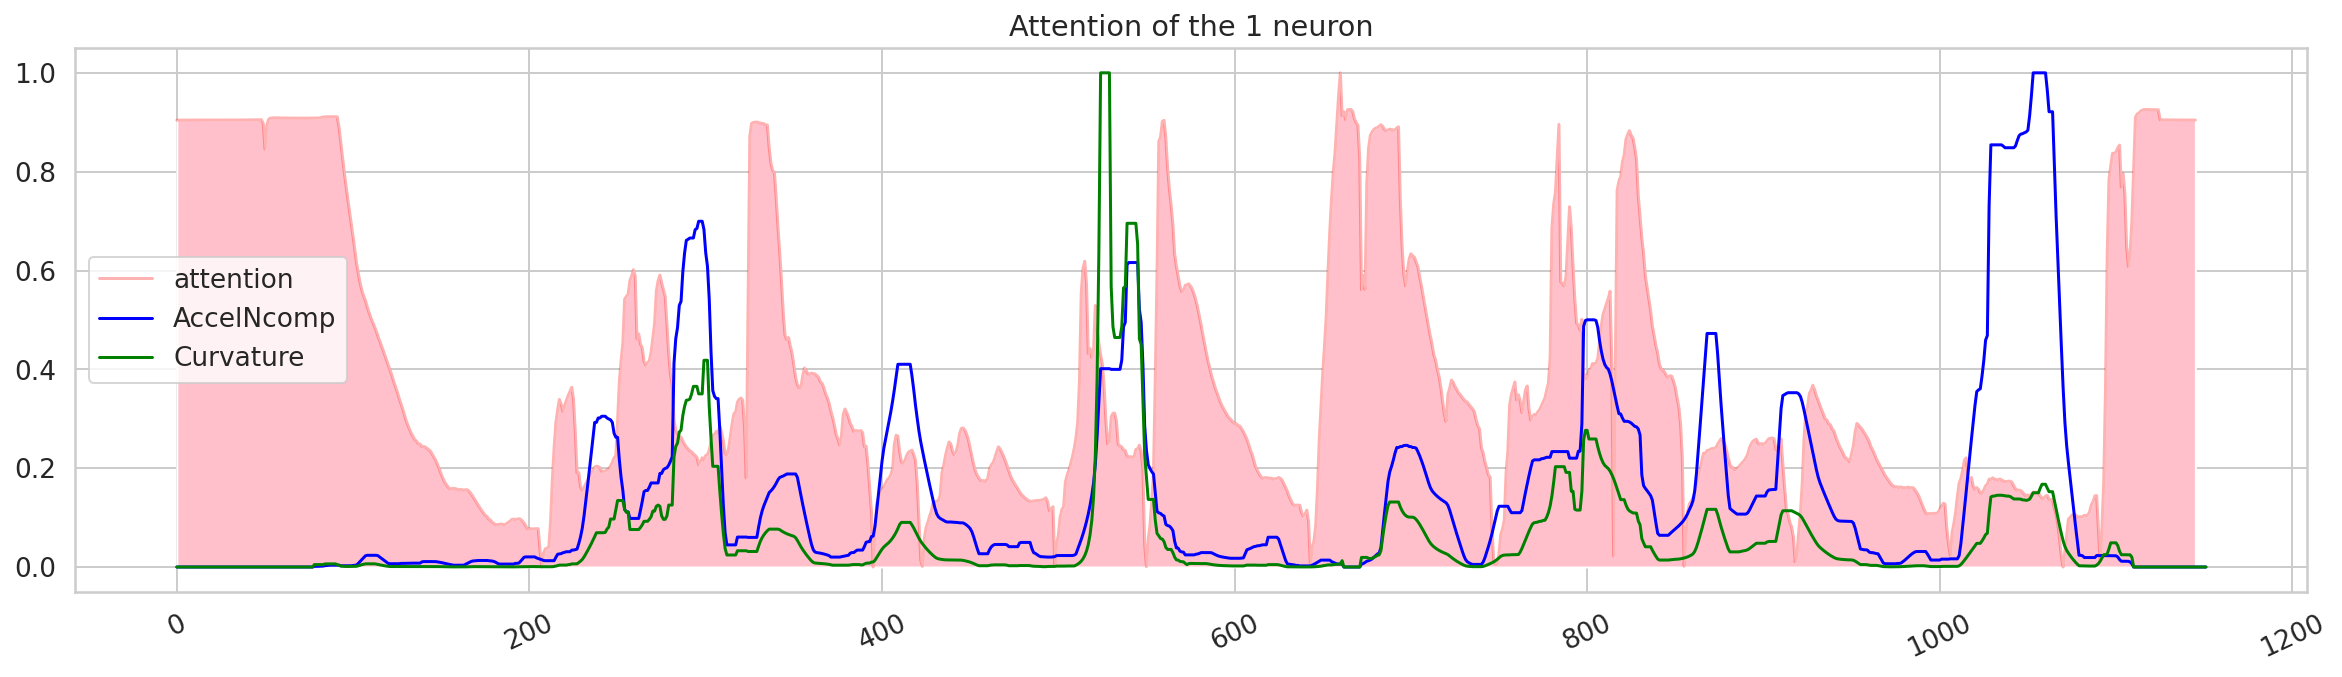

In [ ]:
  attention_norm_2 , feature_1,feature_2 = plot_attention(driver=5,
               lap=2,
               neuron=1,
               f1=1, # Velocity
               f2= 2 # throttlePos
               )

# Neuron 3

In [ ]:
features_

['Velocity',
 'AccelNcomp',
 'Curvature',
 'AT',
 'dynamic_curv',
 'payload.handleSteerPos',
 'payload.frontBrakePos',
 'payload.throttlePos']

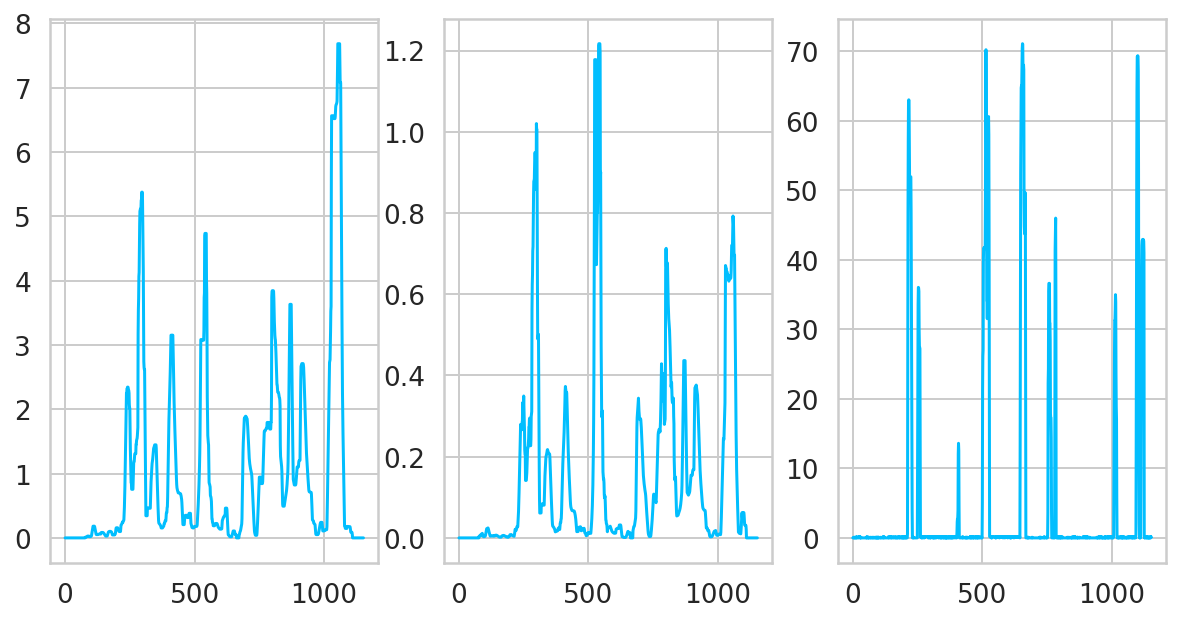

In [ ]:
test = lap_driver(5,2)
fig,axes = plt.subplots(1,3,figsize=(10,5))
axes[0].plot(test["AccelNcomp"])
axes[1].plot(test["dynamic_curv"])
axes[2].plot(test["payload.frontBrakePos"])

In [ ]:
test["AccelNcomp"].corr(test["Curvature"])

0.6217635802949855

In [ ]:
data["AccelNcomp"].corr(data["Curvature"])

0.7057244599008234

In [ ]:
test["AccelNcomp"].corr(test["dynamic_curv"])

0.8906022857511909

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.75785575, 0.7802954 , 0.80265687, 0.82438671, 0.84553928,
        0.86538723, 0.88311174, 0.89870666, 0.91151086, 0.92066048,
        0.92495921, 0.92157432, 0.91344417, 0.90184977, 0.88743594,
        0.87111212, 0.85306229, 0.83325887, 0.81271586, 0.7912958 ,
        0.77040216]),
 <matplotlib.lines.Line2D at 0x7fd34883bba8>)

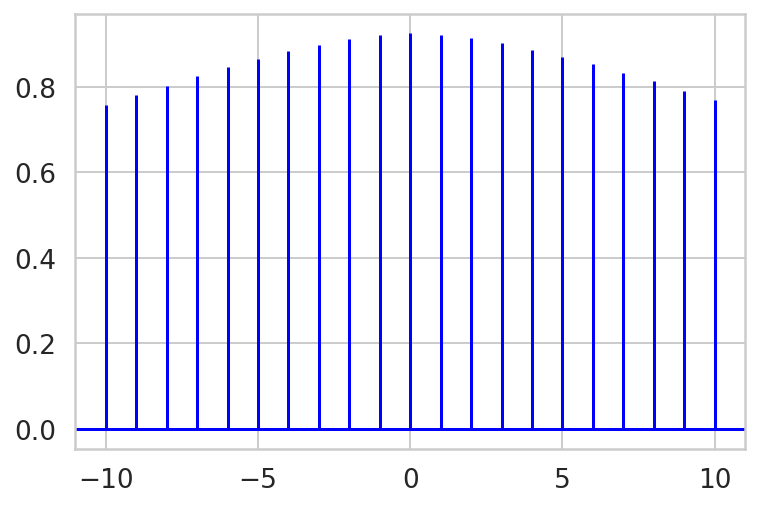

In [ ]:
plt.xcorr(test["AccelNcomp"],test["dynamic_curv"],label="similarity between neuron 0 and Velocity",color="blue")


1152


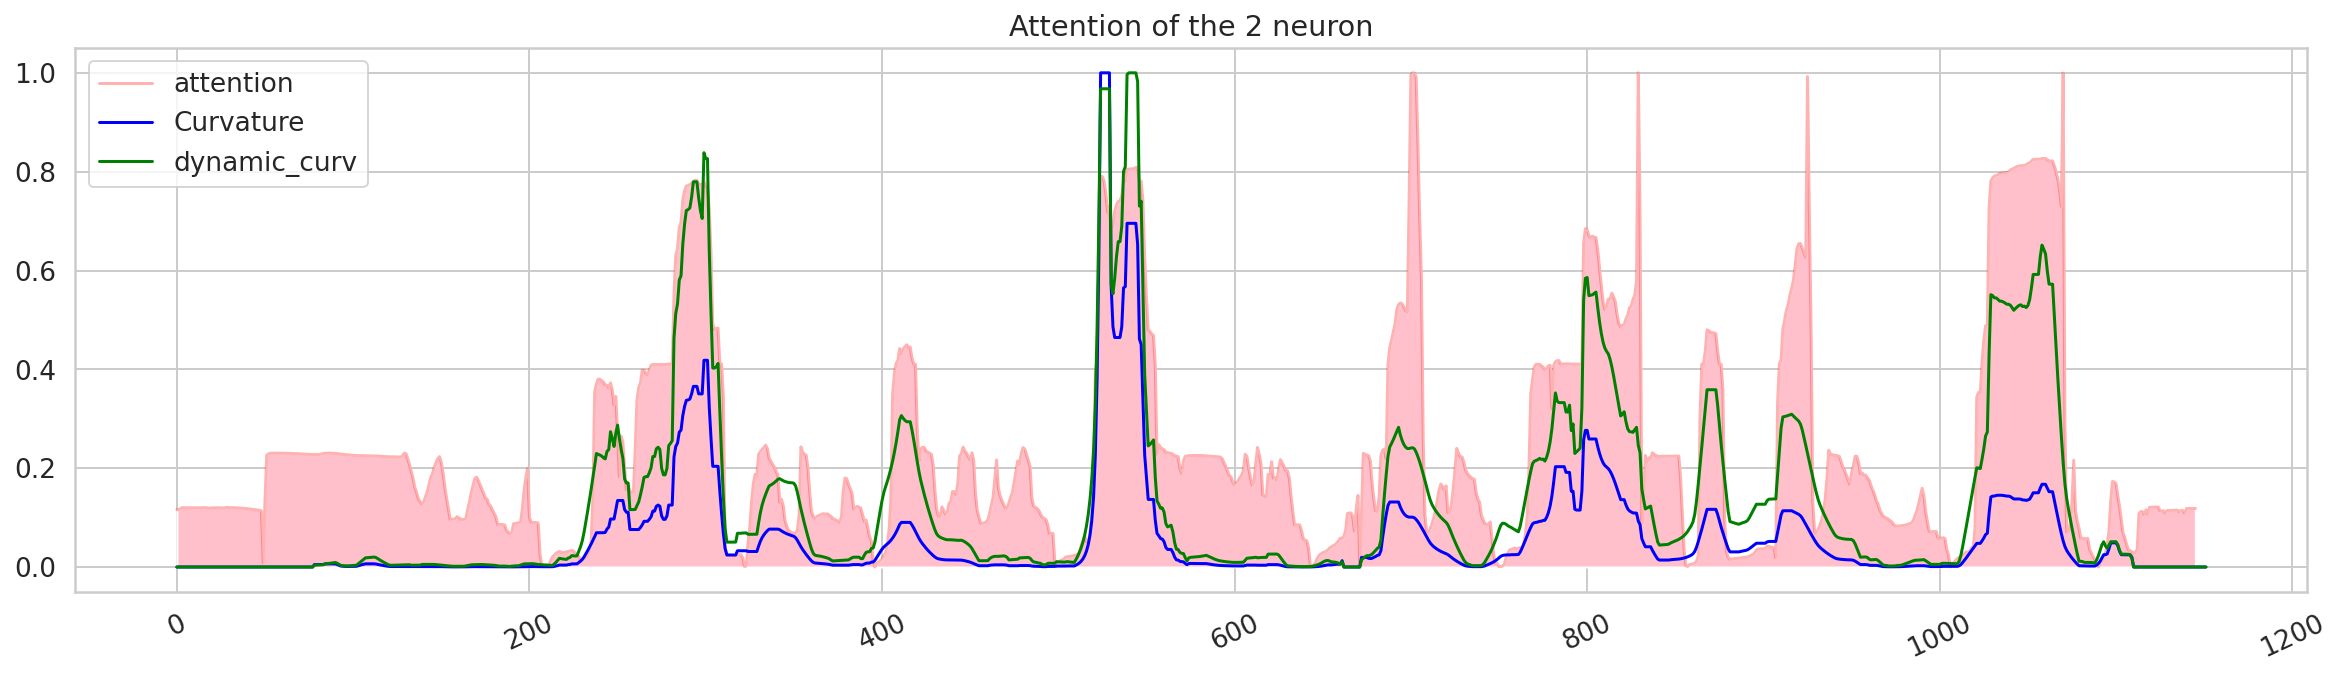

In [ ]:
attention_norm_1 , feature_1,feature_2 = plot_attention(driver=5,
               lap=2,
               neuron=2,
               f1=2, # Velocity
               f2= 4 # throttlePos
               )

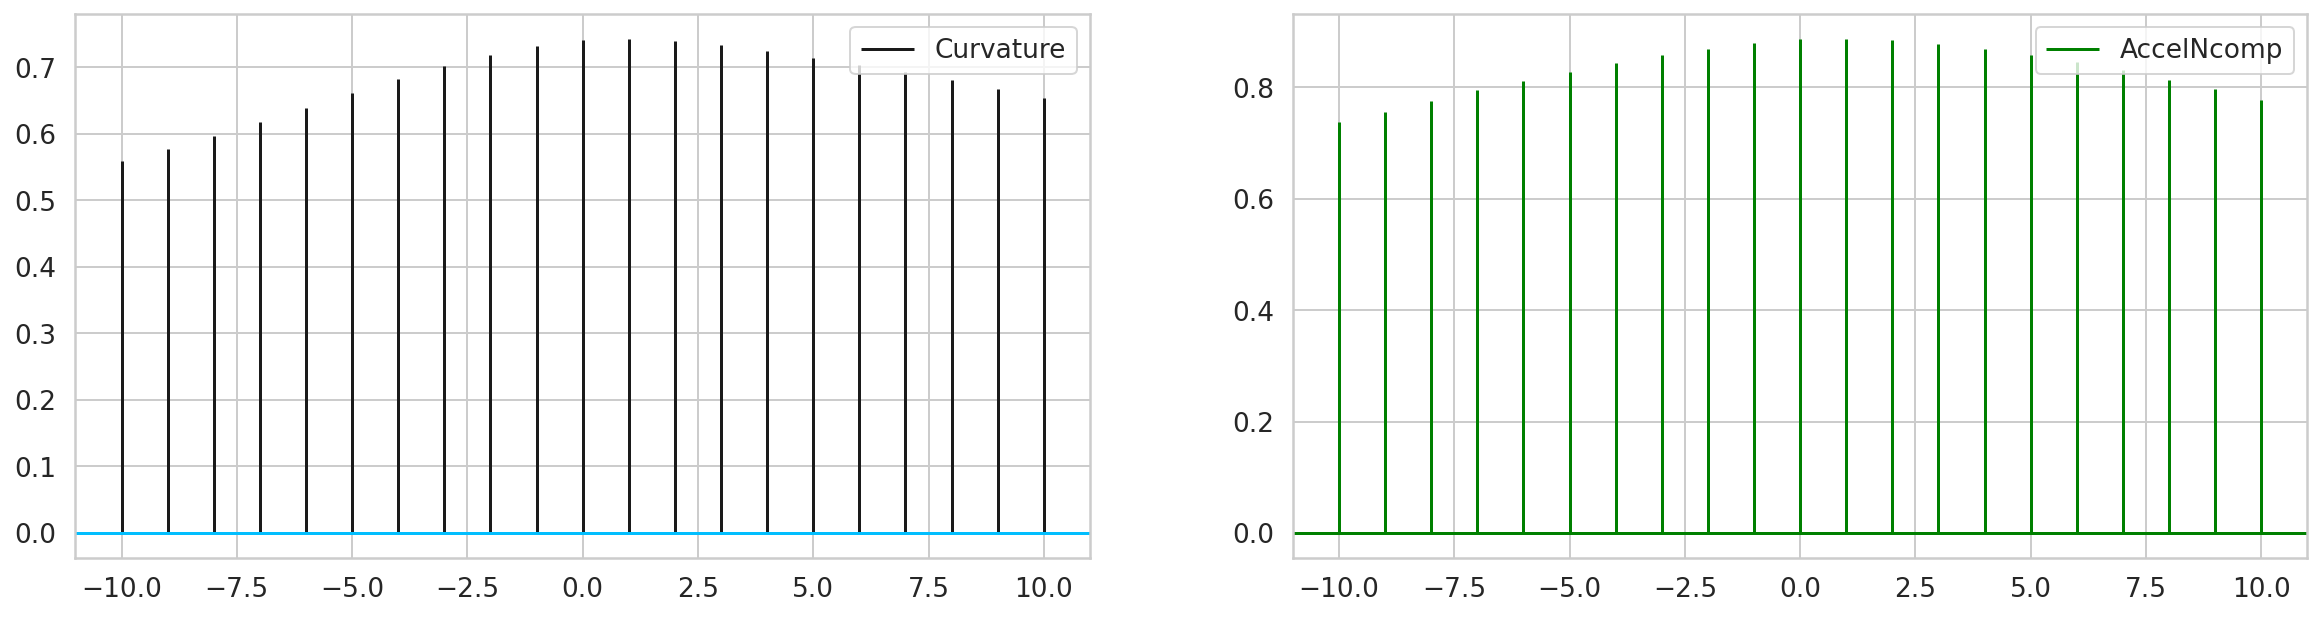

In [ ]:
fig,axes= plt.subplots(1,2,figsize=(20,5))
axes[0].xcorr(attention_norm_1.reshape(-1),feature_1,label="{}".format(features_[2],color="blue"))
axes[1].xcorr(attention_norm_1.reshape(-1),feature_2.reshape(-1),label="{}".format(features_[1]),color="green")
axes[0].legend();
axes[1].legend()


# Are the vectors orthogonals?

In [ ]:
test = lap_driver(5,2)
test = calc_TimeWindowedData(test, TimeWindow, col_use, speed_col_index)
test = create_sequences(test,5)

1152


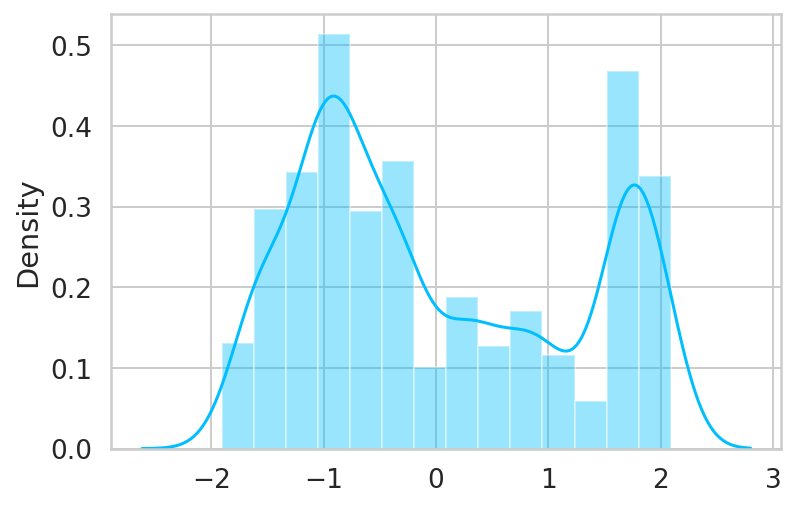

In [ ]:
test = model.to_torch(test.reshape(-1,sequence_length,8)).to(device)

sns.distplot(model.encoder(test).cpu().detach().numpy())

In [ ]:
a = model.encoder(test)
a.shape
encoding_ = model.encoder(test).cpu().detach().numpy()
v1 = encoding_[:,0]
v2 = encoding_[:,1]
v3 = encoding_[:,2]
v1.shape, v2.shape,v3.shape


((1146,), (1146,), (1146,))

In [ ]:
df = pd.DataFrame(encoding_)
df.columns = ['v1','v2','v3']

Text(0.5, 1.0, 'v2 et v3 = -746.7928466796875')

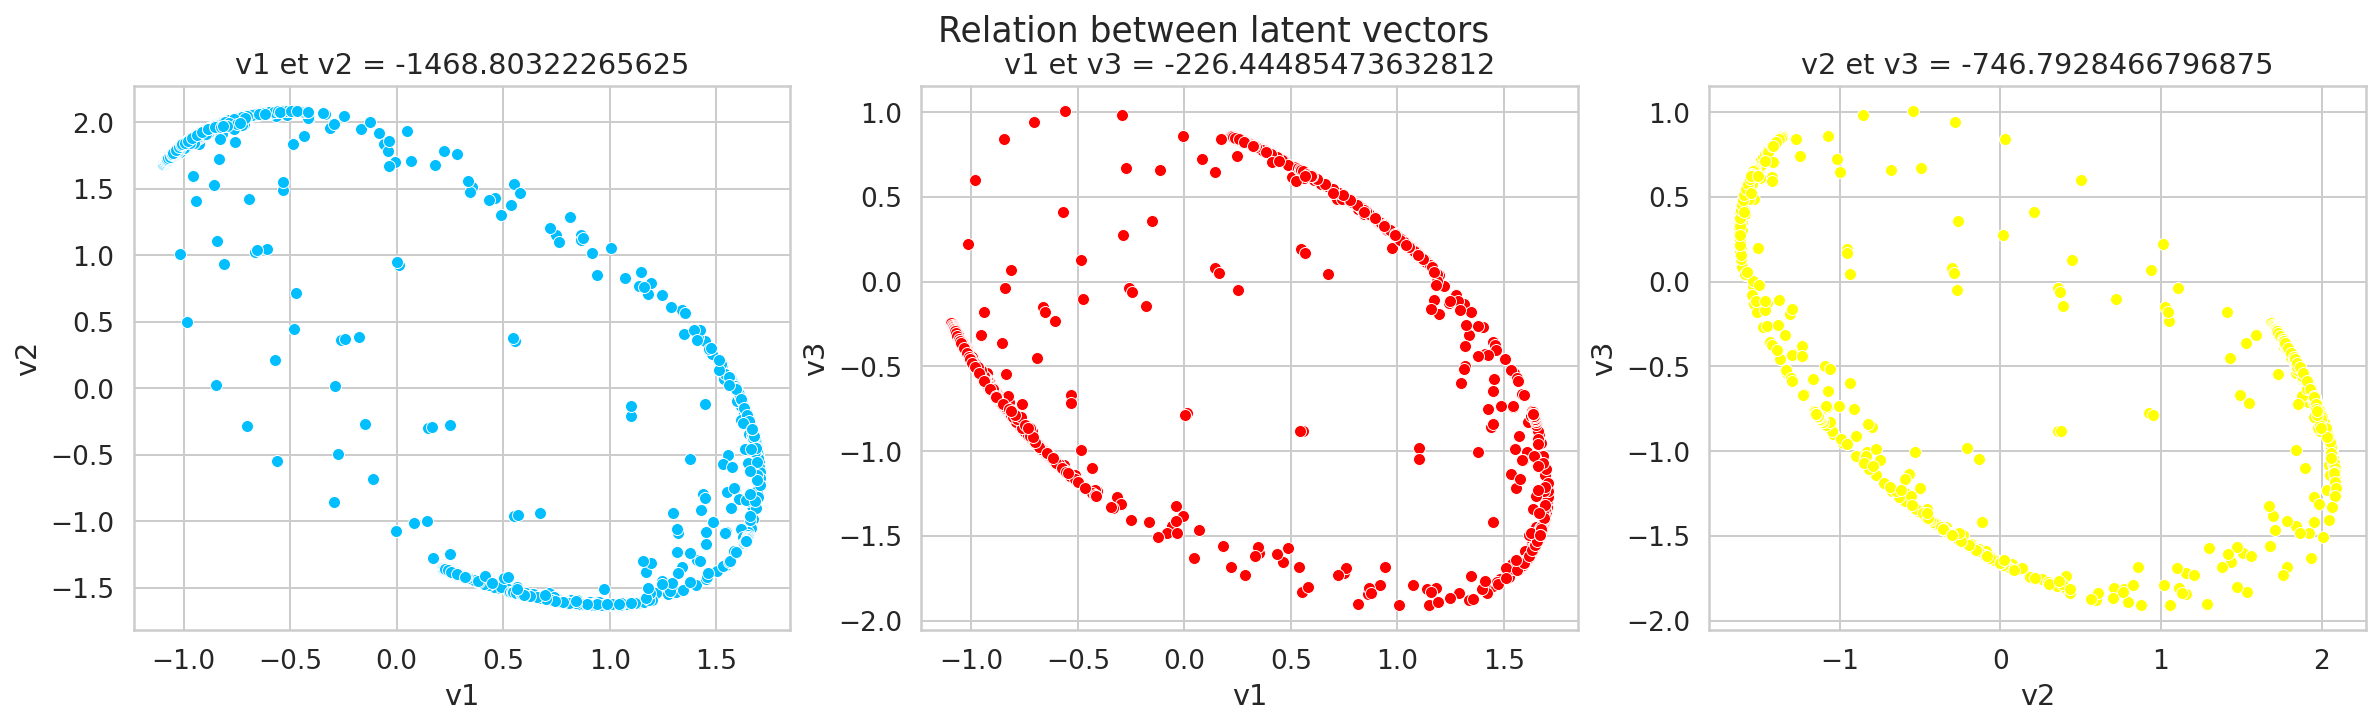

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

fig.suptitle('Relation between latent vectors')

sns.scatterplot(ax=axes[0], data=df, x='v1', y='v2').set_title("v1 et v2 = {}".format(np.sum(v1*v2)))
sns.scatterplot(ax=axes[1], data=df, x='v1', y='v3',color='red').set_title("v1 et v3 = {}".format(np.sum(v1*v3)))
sns.scatterplot(ax=axes[2], data=df, x='v2', y='v3',color='yellow').set_title("v2 et v3 = {}".format(np.sum(v2*v3)))

In [ ]:
#fig = plt.figure(figsize=(20, 5))
#sns.scatterplot(v1,v2) , sns.scatterplot(v2,v3) , sns.scatterplot(v1,v3)

# Visualize LAP

In [ ]:
def visualize_lap(data,model,range_):
  
    hex_list = plot_helper(data,range_ = range_,seq=sequence_length)
    plt.figure(figsize=(20,10))
    PtsList = data.values
    XYpts = PtsList[0:-3+1,[1, 0]]
    XYpts = XYpts[:range_]
    plt.scatter(XYpts[:len(hex_list),1],XYpts[:len(hex_list),0],c=hex_list,linewidth=2)
    
    plt.title("LAP  OF THE TEST DATASET")
    plt.show()

1152


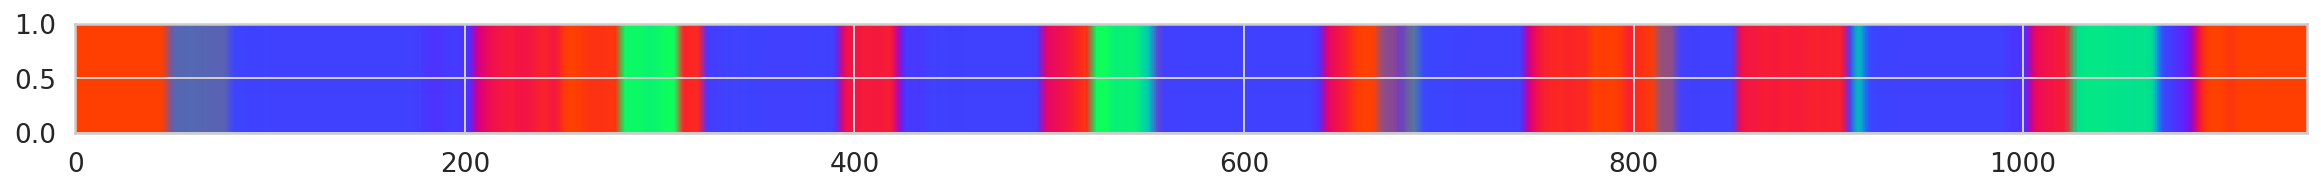

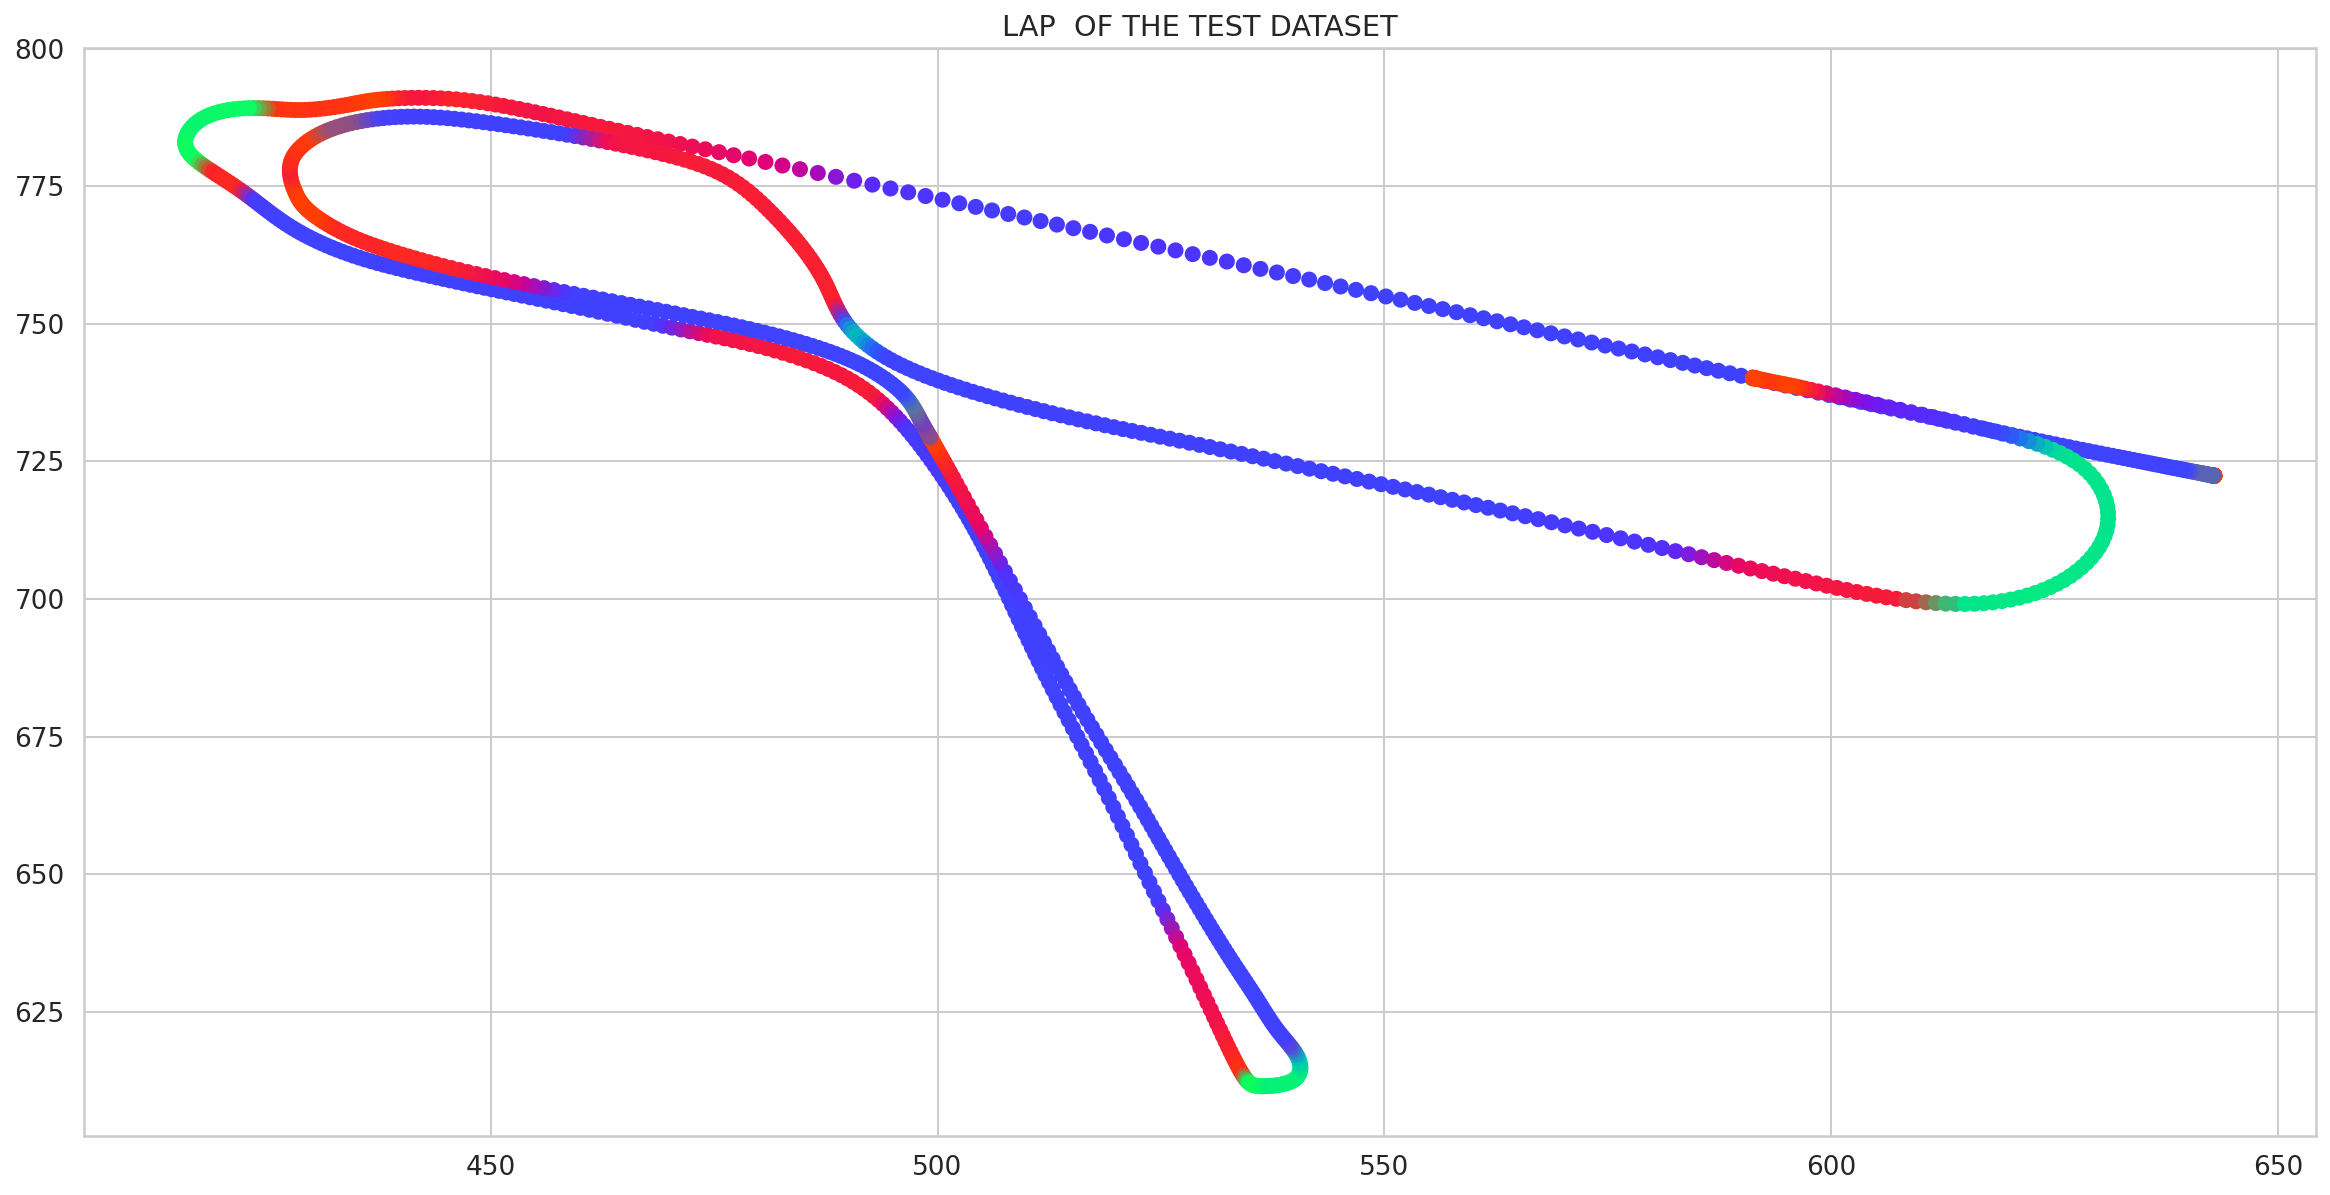

In [ ]:
visualize_lap(df_test,model,df_test.shape[0])

# Feature visualization

In [ ]:
f = ['Velocity','Curvature','AT']

In [ ]:
df_test = lap_driver(5,2)
test = calc_TimeWindowedData(df_test, TimeWindow, col_use, speed_col_index)
test =create_sequences(test,sequence_length)
test =model.to_torch(test).to(device)
encoding_ = model.encoder(test).cpu().detach().numpy()

1152


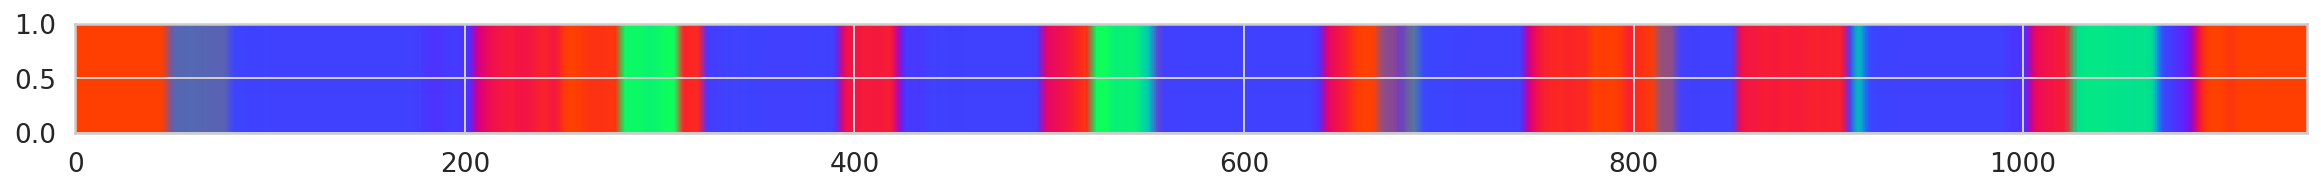

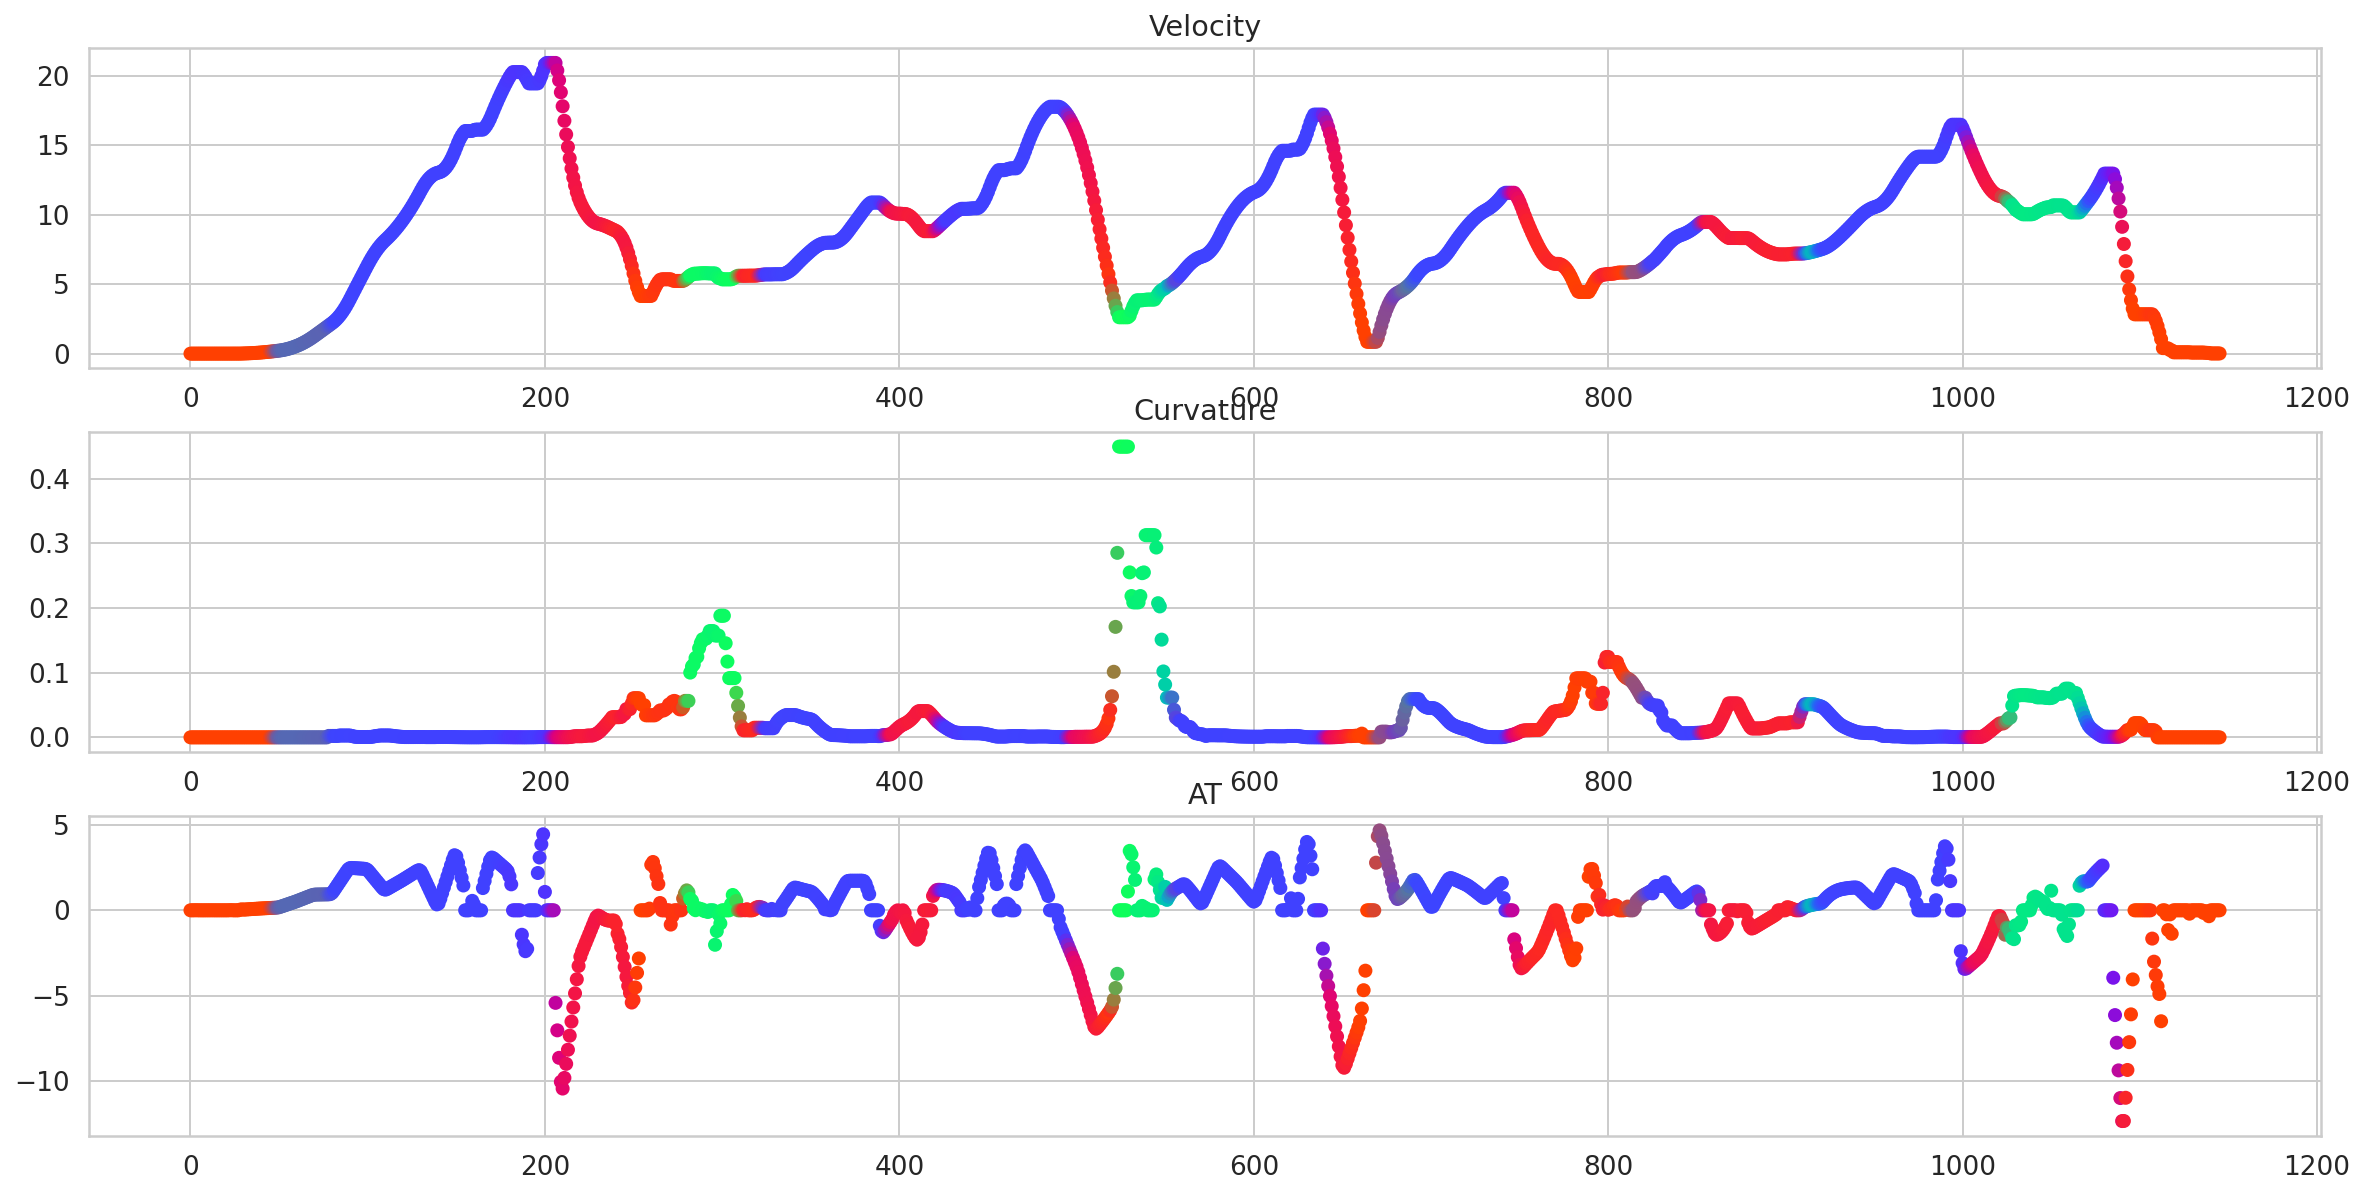

In [ ]:
plot_graph(data,f,convert_to_hex(encoding_,encoding_.shape[0]),5,2)